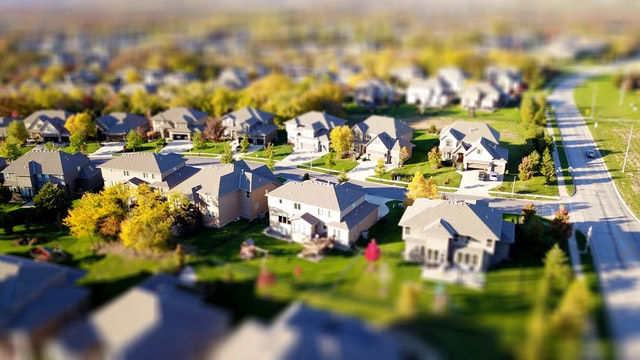
# **A Demographic & Economic Analysis of The United States RE Market with Predictive Property Value Models & Regional Similarity Clustering**


---

**by Dogukan Dalgic**

In [1]:
# necessary packages
!pip install pandasql
!pip install tensorflow
!pip install scikit-learn
!pip install tensorflow-estimator

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=04fd529f2b1bd63ec9dd02ab9a268905b9f9fdf39525405e9a66183c3829679e
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


# Sampling

The script below generates numbers to randomly sample rows from a BigQuery table. A normal distribution is used.

In [2]:
import numpy as np

mu = 3740855  # mean
sigma = 1000000  # standard dev


while True:
    first_number = int(np.random.normal(mu, sigma))
    if 0 <= first_number <= 7481710 - 6000:
        second_number = first_number + 6000  # or use -6000
        if 0 <= second_number <= 7481710:
            break

print("First number:", first_number)
print("Second number:", second_number)

First number: 5485117
Second number: 5491117


# Exploratory Data Analysis

## Data Loading

Below is a sample dataframe created by randomly sampling 2021 US Census Bureau PUMA datasets that will be used for analysis. Access the CSV files on the GitHub repository to run this cell!

In [7]:
# DATA LOADING
import pandas as pd

file_paths = ['/content/bquxjob_10343873_18be3b3a98c.csv', '/content/bquxjob_11fe94f8_18c137c2978.csv',
              '/content/bquxjob_22433658_18c13818228.csv', '/content/bquxjob_2a2c094f_18c137e18cb.csv',
              '/content/bquxjob_2cedc9_18c137f9ec0.csv', '/content/bquxjob_390212c0_18be3b208e7 (1).csv',

              '/content/bquxjob_47222190_18c1382bd65.csv','/content/bquxjob_5cfa83ec_18be3b465c0.csv',
              '/content/bquxjob_5ed557f0_18c137a1bae.csv','/content/bquxjob_6a24c5e8_18be3b4d3be.csv',
              '/content/bquxjob_7c1fbbf6_18be3b53eac.csv','/content/bquxjob_c93aff1_18be3b1fff7.csv']

dataframes = [pd.read_csv(file) for file in file_paths]
hus_pus_21_df = pd.concat(dataframes, ignore_index=True)

In [6]:
# unclean data
print(hus_pus_21_df.shape)
hus_pus_21_df.head()

(38646, 525)


,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80,RowNum
0,H,2018HU0042494,2,3602,1,42,1078962,1093093,26.0,3.0,...,41.0,26.0,30.0,25.0,39.0,7.0,6.0,7.0,25.0,3638588
1,H,2018HU0042495,5,1106,3,24,1078962,1093093,19.0,2.0,...,15.0,17.0,23.0,36.0,5.0,18.0,18.0,16.0,6.0,3638589
2,H,2018HU0042495,5,1106,3,24,1078962,1093093,19.0,2.0,...,16.0,20.0,22.0,38.0,6.0,20.0,18.0,17.0,6.0,3638590
3,H,2018HU0042496,6,2100,3,47,1078962,1093093,16.0,5.0,...,21.0,17.0,24.0,17.0,5.0,21.0,21.0,4.0,4.0,3638591
4,H,2018HU0042496,6,2100,3,47,1078962,1093093,16.0,5.0,...,14.0,9.0,16.0,13.0,3.0,12.0,19.0,2.0,3.0,3638592


**Categories for Housing and Population**

In [8]:
attr_list = ['DIVISION', 'PUMA', 'REGION', 'RT', 'ST', 'SERIALNO', 'AGEP','SEX',
             'PERNP','WAGP','WKHP','MAR','OC','PAOC','DOUT',
             'BDSP','VACS','VALP','ELEP','GASP','WATP','FINCP',
             'GRNTP','SMOCP','MRGP','TAXAMT','CPLT','LAPTOP','INSP',
             'HHLDRAGEP','HHL','ADJINC', 'BDSP','RMSP','BLD','FULP','RNTP','PINCP',
             'YRBLT','VEH','INDP','SCHL','POVPIP','ESR',
             'COW','DRIVESP',
             'HINCP'] # no ['ACCESS', 'TYPE', 'FES', 'YBL']


# dataframe w/ chosen attributes
hp_21_clean = hus_pus_21_df[attr_list]
hp_21_clean.head()

,DIVISION,PUMA,REGION,RT,ST,SERIALNO,AGEP,SEX,PERNP,WAGP,...,PINCP,YRBLT,VEH,INDP,SCHL,POVPIP,ESR,COW,DRIVESP,HINCP
0,2,3602,1,H,42,2018HU0042494,58.0,1.0,25000.0,25000.0,...,27700.0,2000.0,2.0,4971.0,16.0,501.0,1.0,1.0,3.0,127700.0
1,5,1106,3,H,24,2018HU0042495,59.0,2.0,0.0,0.0,...,0.0,2010.0,3.0,9920.0,21.0,501.0,3.0,9.0,NaN,150000.0
2,5,1106,3,H,24,2018HU0042495,56.0,1.0,150000.0,150000.0,...,150000.0,2010.0,3.0,9590.0,22.0,501.0,1.0,5.0,1.0,150000.0
3,6,2100,3,H,47,2018HU0042496,60.0,2.0,4400.0,4400.0,...,4400.0,1960.0,2.0,4580.0,13.0,17.0,1.0,1.0,1.0,5300.0
4,6,2100,3,H,47,2018HU0042496,39.0,2.0,0.0,0.0,...,900.0,1960.0,2.0,NaN,16.0,17.0,6.0,NaN,NaN,5300.0


In [9]:
# attribute datatypes
hp_21_clean.dtypes

DIVISION       int64
PUMA           int64
REGION         int64
RT            object
ST             int64
SERIALNO      object
AGEP         float64
SEX          float64
PERNP        float64
WAGP         float64
WKHP         float64
MAR          float64
OC           float64
PAOC         float64
DOUT         float64
BDSP         float64
VACS         float64
VALP         float64
ELEP         float64
GASP         float64
WATP         float64
FINCP        float64
GRNTP        float64
SMOCP        float64
MRGP         float64
TAXAMT       float64
CPLT         float64
LAPTOP       float64
INSP         float64
HHLDRAGEP    float64
HHL          float64
ADJINC         int64
BDSP         float64
RMSP         float64
BLD          float64
FULP         float64
RNTP         float64
PINCP        float64
YRBLT        float64
VEH          float64
INDP         float64
SCHL         float64
POVPIP       float64
ESR          float64
COW          float64
DRIVESP      float64
HINCP        float64
dtype: object

In [10]:
# division and region assignments
division_names = {
    1: 'New England',
    2: 'Middle Atlantic',
    3: 'East North Central',
    4: 'West North Central',
    5: 'South Atlantic',
    6: 'East Soutch Central',
    7: 'West Soutch Central',
    8: 'Mountain',
    9: 'Pacific'
}

region_names = {
    1: 'Northeast',
    2: 'Midwest',
    3: 'South',
    4: 'West',
}

hp_21_clean['Division_Name'] = hp_21_clean['DIVISION'].map(division_names)
hp_21_clean['Region_Name'] = hp_21_clean['REGION'].map(division_names)

<ipython-input-10-f147d4d30702>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hp_21_clean['Division_Name'] = hp_21_clean['DIVISION'].map(division_names)
<ipython-input-10-f147d4d30702>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hp_21_clean['Region_Name'] = hp_21_clean['REGION'].map(division_names)


Please upload the 'PUMA_infos_data.txt' file onto your session, which can also be found in the data folder on the GitHub repository.

In [12]:
import io

# adding PUMA names into the data
modified_lines = []
with open('/content/PUMA_infos_data.txt', 'r') as file:
    first_line = True
    for line in file:
        if first_line:
            # don't want to edit the header line
            modified_lines.append(line.strip('\n'))
            first_line = False
        else:
            modified_lines.append(line.strip('\n') + '"')

modified_lines[0], modified_lines[1]  = 'ST,PUMA,PUMA_DESC', '01,00100,"Lauderdale, Colbert, Franklin & Marion (Northeast) Counties"'

csv_string = '\n'.join(modified_lines)
csv_file_like_object = io.StringIO(csv_string)
puma_info_df = pd.read_csv(csv_file_like_object)

# merge PUMA_DESC back into hp_21_clean
# hp_21_base is hp_21_clean with added PUMA info.
hp_21_base = hp_21_clean.merge(puma_info_df, on=['ST', 'PUMA'], how='left')

In [13]:
hp_21_base.head()

,DIVISION,PUMA,REGION,RT,ST,SERIALNO,AGEP,SEX,PERNP,WAGP,...,INDP,SCHL,POVPIP,ESR,COW,DRIVESP,HINCP,Division_Name,Region_Name,PUMA_DESC
0,2,3602,1,H,42,2018HU0042494,58.0,1.0,25000.0,25000.0,...,4971.0,16.0,501.0,1.0,1.0,3.0,127700.0,Middle Atlantic,New England,York County (North)--Weigelstown
1,5,1106,3,H,24,2018HU0042495,59.0,2.0,0.0,0.0,...,9920.0,21.0,501.0,3.0,9.0,NaN,150000.0,South Atlantic,East North Central,"Prince George's County (South)--Clinton, Fort ..."
2,5,1106,3,H,24,2018HU0042495,56.0,1.0,150000.0,150000.0,...,9590.0,22.0,501.0,1.0,5.0,1.0,150000.0,South Atlantic,East North Central,"Prince George's County (South)--Clinton, Fort ..."
3,6,2100,3,H,47,2018HU0042496,60.0,2.0,4400.0,4400.0,...,4580.0,13.0,17.0,1.0,1.0,1.0,5300.0,East Soutch Central,East North Central,"Rhea, Marion, Sequatchie, Grundy, Bledsoe & Me..."
4,6,2100,3,H,47,2018HU0042496,39.0,2.0,0.0,0.0,...,NaN,16.0,17.0,6.0,NaN,NaN,5300.0,East Soutch Central,East North Central,"Rhea, Marion, Sequatchie, Grundy, Bledsoe & Me..."


In [14]:
hp_21_base[hp_21_base['PUMA_DESC']=='York County (North)--Weigelstown']

,DIVISION,PUMA,REGION,RT,ST,SERIALNO,AGEP,SEX,PERNP,WAGP,...,INDP,SCHL,POVPIP,ESR,COW,DRIVESP,HINCP,Division_Name,Region_Name,PUMA_DESC
0,2,3602,1,H,42,2018HU0042494,58.0,1.0,25000.0,25000.0,...,4971.0,16.0,501.0,1.0,1.0,3.0,127700.0,Middle Atlantic,New England,York County (North)--Weigelstown
21583,2,3602,1,H,42,2018HU0565658,63.0,1.0,45000.0,45000.0,...,3390.0,19.0,451.0,1.0,1.0,1.0,75140.0,Middle Atlantic,New England,York County (North)--Weigelstown
21584,2,3602,1,H,42,2018HU0565658,61.0,2.0,0.0,0.0,...,6992.0,16.0,451.0,6.0,1.0,NaN,75140.0,Middle Atlantic,New England,York County (North)--Weigelstown
34240,2,3602,1,H,42,2018HU0214808,66.0,1.0,0.0,0.0,...,NaN,20.0,120.0,6.0,NaN,NaN,14500.0,Middle Atlantic,New England,York County (North)--Weigelstown


In [20]:
hp_21_base.dtypes

DIVISION           int64
PUMA               int64
REGION             int64
RT                object
ST                 int64
SERIALNO          object
AGEP             float64
SEX              float64
PERNP            float64
WAGP             float64
WKHP             float64
MAR              float64
OC               float64
PAOC             float64
DOUT             float64
BDSP             float64
VACS             float64
VALP             float64
ELEP             float64
GASP             float64
WATP             float64
FINCP            float64
GRNTP            float64
SMOCP            float64
MRGP             float64
TAXAMT           float64
CPLT             float64
LAPTOP           float64
INSP             float64
HHLDRAGEP        float64
HHL              float64
ADJINC             int64
BDSP             float64
RMSP             float64
BLD              float64
FULP             float64
RNTP             float64
PINCP            float64
YRBLT            float64
VEH              float64


## Distribution & Shape


EDA to explore the distribution of attributes present in the dataset prior to normalization.

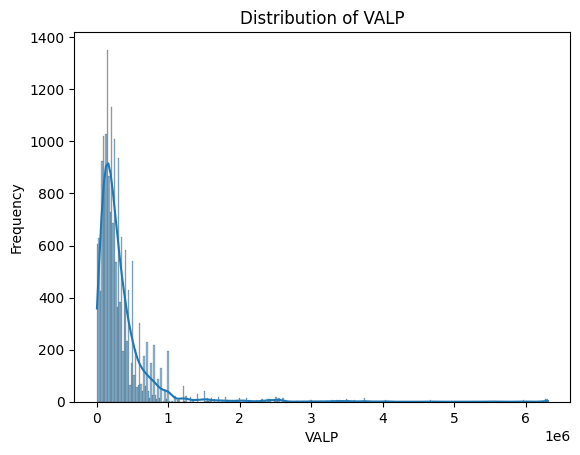

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def hist_dist(df, attr):
  '''
  df: pandas dataframe
  attr: name of column to plot
  '''

  sns.histplot(df[attr], kde=True)  # Histogram with a density plot

  # Plotting with Matplotlib
  # plt.hist(df['attribute'], bins=30)  # Histogram using Matplotlib

  plt.title(f'Distribution of {attr}')
  plt.xlabel(attr)
  plt.ylabel('Frequency')
  plt.show()

hist_dist(hp_21_base, 'VALP')

## Correlation Matrix

The correlation values were also printed out since there are 20+ attributes and it is hard to visualize metrics on the correlation matrix.

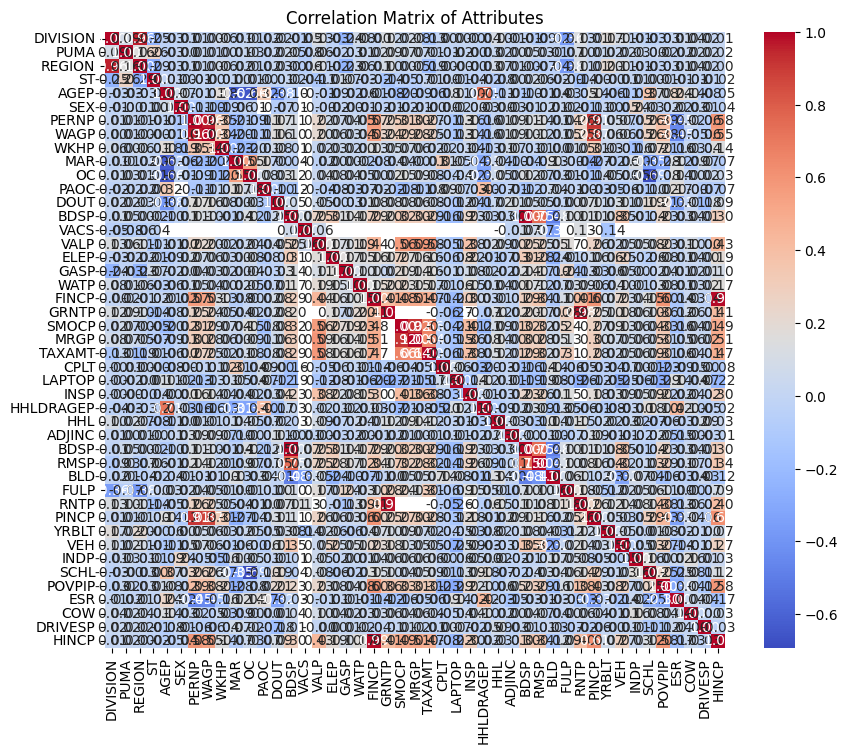

     Attribute_1 Attribute_2  Correlation
0       DIVISION    DIVISION         1.00
1       DIVISION        PUMA         0.09
2       DIVISION      REGION         0.96
3       DIVISION          ST        -0.25
4       DIVISION        AGEP        -0.03
5       DIVISION         SEX        -0.01
6       DIVISION       PERNP         0.01
7       DIVISION        WAGP         0.00
8       DIVISION        WKHP         0.06
9       DIVISION         MAR        -0.01
10      DIVISION          OC         0.01
11      DIVISION        PAOC        -0.02
12      DIVISION        DOUT         0.02
13      DIVISION        BDSP        -0.01
14      DIVISION        VACS        -0.05
15      DIVISION        VALP         0.13
16      DIVISION        ELEP        -0.03
17      DIVISION        GASP        -0.24
18      DIVISION        WATP         0.08
19      DIVISION       FINCP        -0.00
20      DIVISION       GRNTP         0.12
21      DIVISION       SMOCP         0.02
22      DIVISION        MRGP      

In [22]:
import numpy as np

# only numeric data
numeric_data = hp_21_base.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

filtered_corr_matrix = corr_matrix.where((np.abs(corr_matrix) <= 0.6) & (np.abs(corr_matrix) >= 0.2))

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.title('Correlation Matrix of Attributes')
plt.show()

# table format since there are a lot of attributes
corr_pairs = corr_matrix.stack().reset_index()
corr_pairs.columns = ['Attribute_1', 'Attribute_2', 'Correlation']
corr_pairs = corr_pairs.dropna()
corr_pairs['Correlation'] = corr_pairs['Correlation'].round(2)

pd.set_option('display.max_rows', None)
print(corr_pairs)

## 5-Point & Boxplots

Functions producing boxplots which GROUP BY divisions and region.

* **Comment:** 'could be summed into a signle function later.'

VALP


<Figure size 1000x600 with 0 Axes>

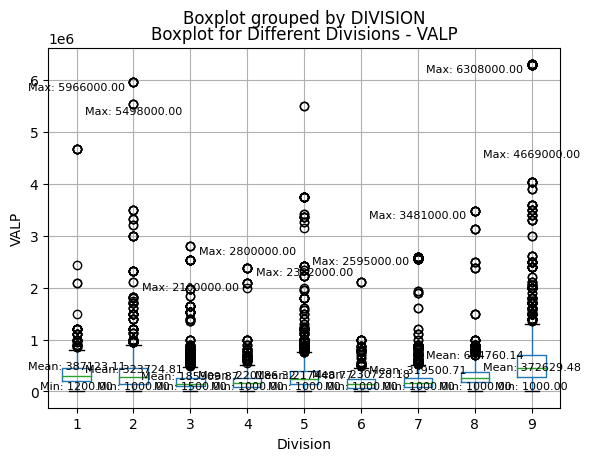

   Division     Min        Max           Mean            std     3-sig(LB)  \
0         2  1200.0  5966000.0  387123.114901  505639.366206 -1.129795e+06   
1         5  1000.0  5498000.0  323724.807594  395992.904155 -8.642539e+05   
2         6  1500.0  2100000.0  185909.865471  192245.856656 -3.908277e+05   
3         3  1000.0  2800000.0  220186.322870  271269.130653 -5.936211e+05   
4         4  1000.0  2382000.0  217448.766737  248553.137359 -5.282106e+05   
5         7  1000.0  2595000.0  230728.177295  312244.467249 -7.060052e+05   
6         8  1000.0  3481000.0  319500.711514  354385.076181 -7.436545e+05   
7         9  1000.0  6308000.0  604760.144678  688978.947298 -1.462177e+06   
8         1  1000.0  4669000.0  372629.475983  402187.891474 -8.339342e+05   

      3-sig(UB)  
0  1.904041e+06  
1  1.511704e+06  
2  7.626474e+05  
3  1.033994e+06  
4  9.631082e+05  
5  1.167462e+06  
6  1.382656e+06  
7  2.671697e+06  
8  1.579193e+06  


<Figure size 1000x600 with 0 Axes>

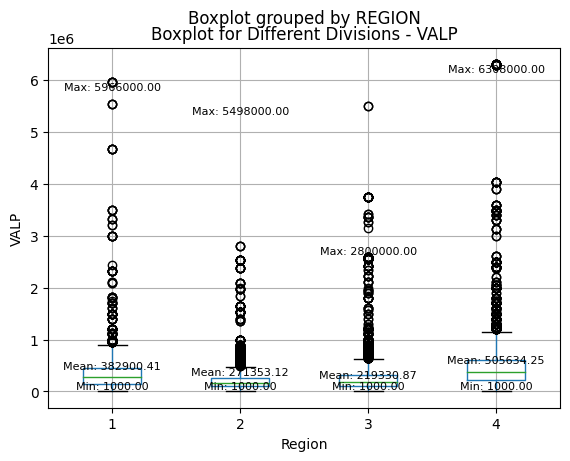

   Region     Min        Max           Mean            std     3-sig(LB)  \
0       1  1000.0  5966000.0  382900.413486  477799.191519 -1.050497e+06   
1       3  1000.0  5498000.0  271353.122063  347679.382436 -7.716850e+05   
2       2  1000.0  2800000.0  219330.874257  264356.211465 -5.737378e+05   
3       4  1000.0  6308000.0  505634.254889  609737.710936 -1.323579e+06   

      3-sig(UB)  
0  1.816298e+06  
1  1.314391e+06  
2  1.012400e+06  
3  2.334847e+06  


In [23]:
import matplotlib.pyplot as plt
column_name = input()
def create_boxplot_for_divisions(df, column_name):
    """
    Create box and whisker plots for different divisions based on a specified column.
    """
    plt.figure(figsize=(10, 6))
    bp = df.boxplot(column=column_name, by='DIVISION', grid=True)

    division_stats = []
    for i, division_name in enumerate(df['DIVISION'].unique()):
        division_data = df[df['DIVISION'] == division_name][column_name].dropna()
        min_val = division_data.min()
        std = division_data.std()
        max_val = division_data.max()
        mean_val = division_data.mean()

        sig_3_ub = mean_val + 3*std
        sig_3_lb = mean_val - 3*std

        positions = i + 1
        division_stats.append({'Division': division_name, 'Min': min_val, 'Max': max_val, 'Mean': mean_val, 'std': std, '3-sig(LB)': sig_3_lb, '3-sig(UB)': sig_3_ub})

        # minimum, maximum, and mean values
        plt.text(positions, min_val, f"Min: {min_val:.2f}", ha='center', va='bottom', fontsize=8, color='black')
        plt.text(positions, max_val, f"Max: {max_val:.2f}", ha='center', va='top', fontsize=8, color='black')
        plt.text(positions, mean_val, f"Mean: {mean_val:.2f}", ha='center', va='bottom', fontsize=8, color='black')

    plt.xlabel('Division')
    plt.ylabel(column_name)
    plt.title(f'Boxplot for Different Divisions - {column_name}')
    plt.show()

    stats_df = pd.DataFrame(division_stats)
    print(stats_df)

create_boxplot_for_divisions(hp_21_clean, column_name
                             )

def create_boxplot_for_region(df, column_name):
    """
    Create box and whisker plots for different regions based on a specified column.
    """
    plt.figure(figsize=(10, 6))
    bp = df.boxplot(column=column_name, by='REGION', grid=True)

    division_stats = []
    for i, division_name in enumerate(df['REGION'].unique()):
        division_data = df[df['REGION'] == division_name][column_name].dropna()
        min_val = division_data.min()
        std = division_data.std()
        max_val = division_data.max()
        mean_val = division_data.mean()

        sig_3_ub = mean_val + 3*std
        sig_3_lb = mean_val - 3*std

        positions = i + 1
        division_stats.append({'Region': division_name, 'Min': min_val, 'Max': max_val, 'Mean': mean_val, 'std': std, '3-sig(LB)': sig_3_lb, '3-sig(UB)': sig_3_ub})

        # Label minimum, maximum, and mean values
        plt.text(positions, min_val, f"Min: {min_val:.2f}", ha='center', va='bottom', fontsize=8, color='black')
        plt.text(positions, max_val, f"Max: {max_val:.2f}", ha='center', va='top', fontsize=8, color='black')
        plt.text(positions, mean_val, f"Mean: {mean_val:.2f}", ha='center', va='bottom', fontsize=8, color='black')

    plt.xlabel('Region')
    plt.ylabel(column_name)
    plt.title(f'Boxplot for Different Divisions - {column_name}')
    plt.show()

    stats_df = pd.DataFrame(division_stats)
    print(stats_df)

create_boxplot_for_region(hp_21_clean, column_name
                             )

## Principal Component Analysis (PCA)

Conducting Principal Component Analysis to understand underlying patterns and trends in the US real estate market helps identify key factors driving property values, streamline large datasets into core components, and enhance the accuracy of predictive models by reducing dimensionality!

### Pre-Processing

In [24]:
# copying hp_21_base since pre-processing needs to take place
pca_df = hp_21_base.copy()
pca_df.drop(columns = ['DIVISION','PUMA','REGION','RT','ST','SERIALNO','Division_Name','Region_Name','PUMA_DESC'], inplace=True)

In [25]:
# binning continious age variables into categorical bins
bins = [0, 18, 29, 39, 49, 59, 100]
labels = ['0-18', '19-29', '30-39', '40-49', '50-59', '60+']
pca_df['AGE_GROUP_AGEP'] = pd.cut(pca_df['AGEP'], bins=bins, labels=labels, right=False)
pca_df['AGE_GROUP_HHLDRAGEP'] = pd.cut(pca_df['AGEP'], bins=bins, labels=labels, right=False)

# replacing (1-2) binary attrs. to (0-1)
binary_12_attrs = ['SEX','DOUT','LAPTOP']
for attr in binary_12_attrs:
  pca_df[attr] = pca_df[attr].map({1: 0, 2: 1})

#'''
#BINARY DOMAINS: SEX(1-2), OC(0-1), DOUT(1-2), LAPTOP (1-2), ADJINC(1-2)
#AGEP, WKHP, ELEP (montly electricity cost), GASP (gas monthly cost), TAXAMT: continuous?
#HHLDRAGEP (age of householder), AGEP: categorical?
#'''

### Standardization & One-Hot Encoding

In [ ]:
pca_df.head(15)

,AGEP,SEX,PERNP,WAGP,WKHP,MAR,OC,PAOC,DOUT,BDSP,...,VEH,INDP,SCHL,POVPIP,ESR,COW,DRIVESP,HINCP,AGE_GROUP_AGEP,AGE_GROUP_HHLDRAGEP
0,58.0,0.0,25000.0,25000.0,43.0,1.0,0.0,NaN,1.0,4.0,...,2.0,4971.0,16.0,501.0,1.0,1.0,3.0,127700.0,50-59,50-59
1,59.0,1.0,0.0,0.0,NaN,1.0,0.0,4.0,1.0,4.0,...,3.0,9920.0,21.0,501.0,3.0,9.0,NaN,150000.0,60+,60+
2,56.0,0.0,150000.0,150000.0,1.0,1.0,0.0,NaN,1.0,4.0,...,3.0,9590.0,22.0,501.0,1.0,5.0,1.0,150000.0,50-59,50-59
3,60.0,1.0,4400.0,4400.0,4.0,3.0,0.0,4.0,1.0,3.0,...,2.0,4580.0,13.0,17.0,1.0,1.0,1.0,5300.0,60+,60+
4,39.0,1.0,0.0,0.0,NaN,5.0,0.0,2.0,1.0,3.0,...,2.0,NaN,16.0,17.0,6.0,NaN,NaN,5300.0,40-49,40-49
5,13.0,0.0,NaN,NaN,NaN,5.0,0.0,NaN,NaN,3.0,...,2.0,NaN,10.0,17.0,NaN,NaN,NaN,5300.0,0-18,0-18
6,8.0,0.0,NaN,NaN,NaN,5.0,0.0,NaN,NaN,3.0,...,2.0,NaN,5.0,17.0,NaN,NaN,NaN,5300.0,0-18,0-18
7,9.0,1.0,NaN,NaN,NaN,5.0,0.0,NaN,NaN,3.0,...,2.0,NaN,6.0,17.0,NaN,NaN,NaN,5300.0,0-18,0-18
8,19.0,0.0,32000.0,32000.0,55.0,5.0,0.0,NaN,1.0,3.0,...,4.0,8270.0,15.0,501.0,1.0,1.0,1.0,167000.0,19-29,19-29
9,51.0,0.0,60000.0,60000.0,50.0,1.0,0.0,NaN,1.0,3.0,...,4.0,770.0,16.0,501.0,1.0,7.0,2.0,167000.0,50-59,50-59


In [26]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [27]:
contin_attrs = ['PERNP', 'WAGP', 'WKHP', 'VALP', 'WATP', 'FINCP', 'GRNTP', 'SMOCP',
                'MRGP', 'INSP', 'AGEP', 'HHLDRAGEP', 'ELEP','GASP','TAXAMT','ADJINC', 'VEH', 'INDP', 'SCHL','HINCP','FULP',
                'RNTP','PINCP','SCHL','HINCP']
binary_attrs = ['SEX', 'OC', 'DOUT', 'LAPTOP']
categ_attrs = ['MAR','PAOC','BDSP','VACS','CPLT','HHL','AGE_GROUP_AGEP','AGE_GROUP_HHLDRAGEP', 'POVPIP', 'ESR', 'COW','RMSP','BLD','YRBLT','DRIVESP']

In [28]:
# standardization for continuous attrs
scaler = StandardScaler()
standardize_cols = contin_attrs

pca_df[standardize_cols] = scaler.fit_transform(pca_df[standardize_cols])

In [ ]:
pca_df.head()

,AGEP,SEX,PERNP,WAGP,WKHP,MAR,OC,PAOC,DOUT,BDSP,...,VEH,INDP,SCHL,POVPIP,ESR,COW,DRIVESP,HINCP,AGE_GROUP_AGEP,AGE_GROUP_HHLDRAGEP
0,0.686431,0.0,0.007188,0.042500,0.437979,1.0,0.0,NaN,1.0,4.0,...,-0.145945,-0.584974,-0.049322,501.0,1.0,1.0,3.0,0.276988,50-59,50-59
1,0.728160,1.0,-0.466586,-0.456582,NaN,1.0,0.0,4.0,1.0,4.0,...,0.698099,1.292547,0.915848,501.0,3.0,9.0,NaN,0.497771,60+,60+
2,0.602972,0.0,2.376060,2.537912,-2.485832,1.0,0.0,NaN,1.0,4.0,...,0.698099,1.167353,1.108881,501.0,1.0,5.0,1.0,0.497771,50-59,50-59
3,0.769889,1.0,-0.383202,-0.368744,-2.276988,3.0,0.0,4.0,1.0,3.0,...,-0.145945,-0.733309,-0.628423,17.0,1.0,1.0,1.0,-0.934840,60+,60+
4,-0.106428,1.0,-0.466586,-0.456582,NaN,5.0,0.0,2.0,1.0,3.0,...,-0.145945,NaN,-0.049322,17.0,6.0,NaN,NaN,-0.934840,40-49,40-49


In [29]:
# one-hot encoding for categorical attrs
encoder = OneHotEncoder(sparse=False)
one_hot_cols = categ_attrs


encoded_columns = pd.DataFrame(encoder.fit_transform(pca_df[one_hot_cols]))
print(f"Number of features in input DataFrame: {len(pca_df[one_hot_cols].columns)}")
print(f"Number of feature names in encoder: {len(encoder.get_feature_names_out())}")
encoded_columns.columns = encoder.get_feature_names_out()

# drop original columns and concatenate new one-hot encoded columns
pca_df_copy = pca_df.copy()
pca_df_copy.drop(one_hot_cols, axis=1, inplace=True)
pca_processed_df = pd.concat([pca_df_copy, encoded_columns], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Number of features in input DataFrame: 16
Number of feature names in encoder: 631


In [ ]:
pca_processed_df.head()

,AGEP,SEX,PERNP,WAGP,WKHP,OC,DOUT,VALP,ELEP,GASP,...,YRBLT_2000.0,YRBLT_2010.0,YRBLT_nan,DRIVESP_1.0,DRIVESP_2.0,DRIVESP_3.0,DRIVESP_4.0,DRIVESP_5.0,DRIVESP_6.0,DRIVESP_nan
0,0.686431,0.0,0.007188,0.042500,0.437979,0.0,1.0,-0.745801,0.853026,-0.082487,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.728160,1.0,-0.466586,-0.456582,NaN,0.0,1.0,0.044331,-0.633271,-0.454159,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.602972,0.0,2.376060,2.537912,-2.485832,0.0,1.0,0.044331,-0.633271,-0.454159,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.769889,1.0,-0.383202,-0.368744,-2.276988,0.0,1.0,-0.646582,1.249372,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.106428,1.0,-0.466586,-0.456582,NaN,0.0,1.0,-0.646582,1.249372,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
pca_processed_df.columns # NaN values are labeled as 1 in '%_nan' columns

Index(['AGEP', 'SEX', 'PERNP', 'WAGP', 'WKHP', 'OC', 'DOUT', 'VALP', 'ELEP',
       'GASP',
       ...
       'YRBLT_2000.0', 'YRBLT_2010.0', 'YRBLT_nan', 'DRIVESP_1.0',
       'DRIVESP_2.0', 'DRIVESP_3.0', 'DRIVESP_4.0', 'DRIVESP_5.0',
       'DRIVESP_6.0', 'DRIVESP_nan'],
      dtype='object', length=658)

### Data Imputation

Checking NaNs in each attribute prior to testing imputation strategies on them.

In [31]:
nan_count_per_column = pca_processed_df.isna().sum()
print('pca_df shape:', pca_processed_df.shape)

# printing NaN counts for each type of attribute
print("\nContinuous Attributes NaN Counts:")
for attr in contin_attrs:
    if attr in nan_count_per_column:
        print(f"{attr}: {nan_count_per_column[attr]}")
    else:
        print(f"Missing or Mismatched Continuous Attribute: {attr}")

print("\nBinary Attributes NaN Counts:")
for attr in binary_attrs:
    if attr in nan_count_per_column:
        print(f"{attr}: {nan_count_per_column[attr]}")
    else:
        print(f"Missing or Mismatched Binary Attribute: {attr}")

print("\nCategorical Attributes NaN Counts:")
for attr in categ_attrs:
    if attr in nan_count_per_column:
        print(f"{attr}: {nan_count_per_column[attr]}")
    else:
        print(f"Missing or Mismatched Categorical Attribute: {attr}")

pca_df shape: (38646, 658)

Continuous Attributes NaN Counts:
PERNP: 6328
WAGP: 5923
WKHP: 20367
VALP: 19065
WATP: 19125
FINCP: 15997
GRNTP: 31324
SMOCP: 19162
MRGP: 25956
INSP: 19162
AGEP: 1125
HHLDRAGEP: 11424
ELEP: 12364
GASP: 23891
TAXAMT: 19162
ADJINC: 0
VEH: 11424
INDP: 17364
SCHL: 1966
HINCP: 11424
FULP: 36199
RNTP: 31142
PINCP: 5923
SCHL: 1966
HINCP: 11424

Binary Attributes NaN Counts:
SEX: 1125
OC: 11424
DOUT: 5923
LAPTOP: 11424

Categorical Attributes NaN Counts:
Missing or Mismatched Categorical Attribute: MAR
Missing or Mismatched Categorical Attribute: PAOC
Missing or Mismatched Categorical Attribute: BDSP
Missing or Mismatched Categorical Attribute: VACS
Missing or Mismatched Categorical Attribute: CPLT
Missing or Mismatched Categorical Attribute: HHL
Missing or Mismatched Categorical Attribute: AGE_GROUP_AGEP
Missing or Mismatched Categorical Attribute: AGE_GROUP_HHLDRAGEP
Missing or Mismatched Categorical Attribute: POVPIP
Missing or Mismatched Categorical Attribute: E

* **Continuous attributes with excessive amount of NaN values:** *WKHP, VALP, GASP, WATP, GRNTP, SMOCP, MRGP, TAXAMT, CPLT, INSP*

* **Attributes with normal dist. :** *AGEP, WKHP, HHLDRAGEP*

* **Attributes with skewed dist. :** *PERNP, WAGP, VALP, ELEP, GASP, WATP, FINCP, GRNTP, SMOCP, MRGP, TAXAMT, INSP*


---
* **Categorical attributes with excessive amount of NaN values:** *PAOC, VACS, CPLT*






#### Strategy 1: Imputing Continuous NaNs Ignoring Sparsity

In [32]:
norm_dist_attrs = ['AGEP', 'WKHP', 'HHLDRAGEP']
skewed_dist_attrs = ['PERNP', 'WAGP', 'VALP', 'ELEP', 'GASP', 'WATP', 'FINCP', 'GRNTP', 'SMOCP',
                     'MRGP', 'TAXAMT', 'INSP','WATP','ADJINC','VEH','INDP','FULP',
                     'RNTP','PINCP', 'SCHL','HINCP'] #SCHL is questionable

pca_imputed_strat1 = pca_processed_df.copy()
# imputing mean for normally distributed attributes
for attr in norm_dist_attrs:
    mean_val = pca_imputed_strat1[attr].mean()
    pca_imputed_strat1[attr].fillna(mean_val, inplace=True)

# imputing median for skewed attributes
for attr in skewed_dist_attrs:
    median_val = pca_imputed_strat1[attr].median()
    pca_imputed_strat1[attr].fillna(median_val, inplace=True)


In [33]:
# imputing mode for binary attributes
for attr in binary_attrs:
  mode_val = pca_imputed_strat1[attr].mode()[0]
  #print(mode_val)
  pca_imputed_strat1[attr].fillna(mode_val, inplace=True)

In [ ]:
pca_imputed_strat1.head()

,AGEP,SEX,PERNP,WAGP,WKHP,OC,DOUT,VALP,ELEP,GASP,...,YRBLT_2000.0,YRBLT_2010.0,YRBLT_nan,DRIVESP_1.0,DRIVESP_2.0,DRIVESP_3.0,DRIVESP_4.0,DRIVESP_5.0,DRIVESP_6.0,DRIVESP_nan
0,0.686431,0.0,0.007188,0.042500,4.379785e-01,0.0,1.0,-0.745801,0.853026,-0.082487,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.728160,1.0,-0.466586,-0.456582,3.109766e-17,0.0,1.0,0.044331,-0.633271,-0.454159,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.602972,0.0,2.376060,2.537912,-2.485832e+00,0.0,1.0,0.044331,-0.633271,-0.454159,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.769889,1.0,-0.383202,-0.368744,-2.276988e+00,0.0,1.0,-0.646582,1.249372,-0.330269,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.106428,1.0,-0.466586,-0.456582,3.109766e-17,0.0,1.0,-0.646582,1.249372,-0.330269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [35]:
# double checking imputation was successfull
nans_per_column = pca_imputed_strat1.isna().sum()
high_nans = nans_per_column[nans_per_column > 0]
print(high_nans)

Series([], dtype: int64)


#### Strategy 2: Imputing NaNs Using Auto-Encoders

In [36]:
pca_df_strat2 = pca_processed_df.copy()

In [37]:
pca_df_strat2.columns

Index(['AGEP', 'SEX', 'PERNP', 'WAGP', 'WKHP', 'OC', 'DOUT', 'VALP', 'ELEP',
       'GASP',
       ...
       'YRBLT_2000.0', 'YRBLT_2010.0', 'YRBLT_nan', 'DRIVESP_1.0',
       'DRIVESP_2.0', 'DRIVESP_3.0', 'DRIVESP_4.0', 'DRIVESP_5.0',
       'DRIVESP_6.0', 'DRIVESP_nan'],
      dtype='object', length=658)

In [44]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim

# ---- PRE-PROCESSING ----

# splitting data into training and validation sets
nan_mask = pca_df_strat2.isna()
pca_df_strat2_filled = pca_df_strat2.fillna(0)
X_train, X_val = train_test_split(pca_df_strat2_filled, test_size=0.3, random_state=42)

# converting into torch sensors
train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
val_tensor = torch.tensor(X_val.values, dtype=torch.float32)

# data loaders
train_data = TensorDataset(train_tensor, train_tensor) # autoencoders use the same input for both input and target
val_data = TensorDataset(val_tensor, val_tensor)

batch_size = 64 # adjust later?
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(val_data, batch_size=batch_size)

##### Model Training

In [45]:
# ---- Auto-encoder Class ----
class Autoencoder(nn.Module):
    def __init__(self, data_tensor, latent_dim):
        super(Autoencoder, self).__init__()

        # inputs
        self.data_tensor = data_tensor
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(data_tensor.shape[1], 20),
            nn.ReLU(),
            nn.Linear(20, 14),
            nn.ReLU(),
            nn.Linear(14, self.latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 14),
            nn.ReLU(),
            nn.Linear(14, 20),
            nn.ReLU(),
            nn.Linear(20, data_tensor.shape[1]),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [46]:
# checking GPU resources
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---TRAINING---
def train_ae(model, train_loader, validation_loader, num_epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # store losses
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for inputs, _ in train_loader:
            inputs = inputs.to(device)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            # backward prop. and Adam
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, _ in validation_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                total_val_loss += loss.item()

        # avg. loss
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_val_loss = total_val_loss / len(validation_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


Using device: cpu


torch.Size([1, 658])
Epoch [1/20], Train Loss: 0.0006, Validation Loss: 0.0004
Epoch [2/20], Train Loss: 0.0004, Validation Loss: 0.0003
Epoch [3/20], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [4/20], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [5/20], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [6/20], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [7/20], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [8/20], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [9/20], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [10/20], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [11/20], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [12/20], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [13/20], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [14/20], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [15/20], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [16/20], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [17/20], Train Loss: 0.0003, Validatio

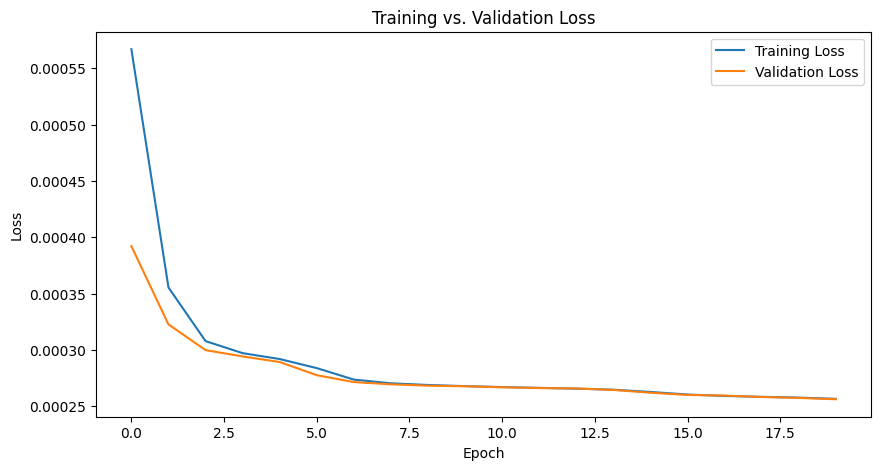

In [47]:
sample_tensor = train_tensor[:1] # for shape purposes
print(sample_tensor.shape)
model = Autoencoder(sample_tensor, latent_dim = 8)

train_losses, val_losses = train_ae(model, train_loader, validation_loader, num_epochs=20, lr=0.001)

# plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

**Comments**


---
The stable and low training and validation losses (both at 0.0003) suggest that the autoencoder model is performing well without clear signs of overfitting. Should continue monitoring performance and possibly validate the imputation quality with additional metrics or visual inspection of reconstructed data.

**Note:** 'this approach has been churned since it is hard to interpret imputations and further investigation into changes in attribute distributions is necessary.'

##### Imputation

In [48]:
# generate df obtained from autoencoder
data_tensor = torch.tensor(pca_df_strat2_filled.values, dtype=torch.float32)
dataset = TensorDataset(data_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=False)

# pass pca_df_strat2_filled through the autoencoder
model.eval()
imputed_values = []
with torch.no_grad():
    for inputs, in data_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        imputed_values.append(outputs.cpu().numpy())

# concatonate all output batches
imputed_values = np.concatenate(imputed_values, axis=0)

# convert back to pd df
imputed_df = pd.DataFrame(imputed_values, columns=pca_df_strat2_filled.columns)

# replace initially imputed values in the original DataFrame
nan_mask = pca_df_strat2_filled.isna()
pca_ae_imputed_df = pca_df_strat2_filled.where(~nan_mask, imputed_df)
pca_imputed_strat2 = pca_ae_imputed_df.copy()

In [49]:
pca_imputed_strat2.info() # successfully imputed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38646 entries, 0 to 38645
Columns: 658 entries, AGEP to DRIVESP_nan
dtypes: float64(658)
memory usage: 194.0 MB


In [50]:
pca_imputed_strat1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38646 entries, 0 to 38645
Columns: 658 entries, AGEP to DRIVESP_nan
dtypes: float64(658)
memory usage: 194.0 MB


### Running PCA

In [51]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def fit_PCA(df, strat_name, n_components=10):
    model = PCA(n_components)
    data = df.to_numpy()
    model.fit(data)

    # transform data
    x_pca = model.transform(data)

    components = model.components_

    feature_names = df.columns

    # for each component, identify the top 5 features
    for i, component in enumerate(components):
        # sort feature importances by absolute value (in descending order)
        indices = np.argsort(np.abs(component))[::-1][:8]  # top 8 indices
        features = feature_names[indices]
        scores = component[indices]

        print(f"Principal Component {i+1}:")
        for feature, score in zip(features, scores):
            print(f"  {feature}: {score:.4f}")
        print()

    # ---- PLOTTING ----
    plt.figure(figsize=(10, 6))

    # bar plot for explained variance
    sns.barplot(x=np.arange(1, n_components + 1), y=model.explained_variance_ratio_, palette='coolwarm')

    plt.xlabel('PCA Components', fontsize=10)
    plt.ylabel('Variance Ratio', fontsize=10)
    plt.title(f'PCA Components and Variance Ratio - {strat_name}', fontsize=15)

    # cumulative sum line
    plt.twinx()
    plt.plot(np.arange(1, n_components + 1), np.cumsum(model.explained_variance_ratio_), color='red', marker='o')
    plt.ylabel('Cumulative Explained Variance', fontsize=10)

    plt.show()


Principal Component 1:
  PERNP: 0.3774
  PINCP: 0.3725
  WAGP: 0.3724
  HINCP: 0.2932
  FINCP: 0.2508
  TAXAMT: 0.1741
  SMOCP: 0.1713
  VALP: 0.1495

Principal Component 2:
  AGEP: -0.5473
  SCHL: -0.3716
  HHLDRAGEP: -0.3149
  MAR_5.0: 0.1852
  AGE_GROUP_HHLDRAGEP_60+: -0.1843
  AGE_GROUP_AGEP_60+: -0.1843
  AGE_GROUP_HHLDRAGEP_0-18: 0.1809
  AGE_GROUP_AGEP_0-18: 0.1809

Principal Component 3:
  ADJINC: -0.3187
  BDSP_nan: 0.2358
  RMSP_nan: 0.2358
  YRBLT_nan: 0.2358
  BLD_nan: 0.2358
  BDSP_nan: 0.2358
  HHL_nan: 0.2350
  HINCP: 0.2038

Principal Component 4:
  HHLDRAGEP: 0.3110
  AGEP: 0.2647
  VALP: 0.2592
  TAXAMT: 0.2591
  WAGP: -0.2418
  SMOCP: 0.2341
  PERNP: -0.2307
  INSP: 0.2076

Principal Component 5:
  SCHL: -0.4635
  VEH: -0.3361
  PINCP: 0.3032
  COW_nan: 0.2345
  PERNP: 0.2331
  WAGP: 0.2228
  COW_1.0: -0.1750
  ELEP: -0.1716

Principal Component 6:
  ADJINC: 0.6083
  VEH: -0.4297
  ELEP: -0.2855
  SCHL: 0.2235
  TAXAMT: 0.1979
  VALP: 0.1836
  SMOCP: 0.1784
  MRGP: 0

<ipython-input-51-858bd73fb437>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(1, n_components + 1), y=model.explained_variance_ratio_, palette='coolwarm')


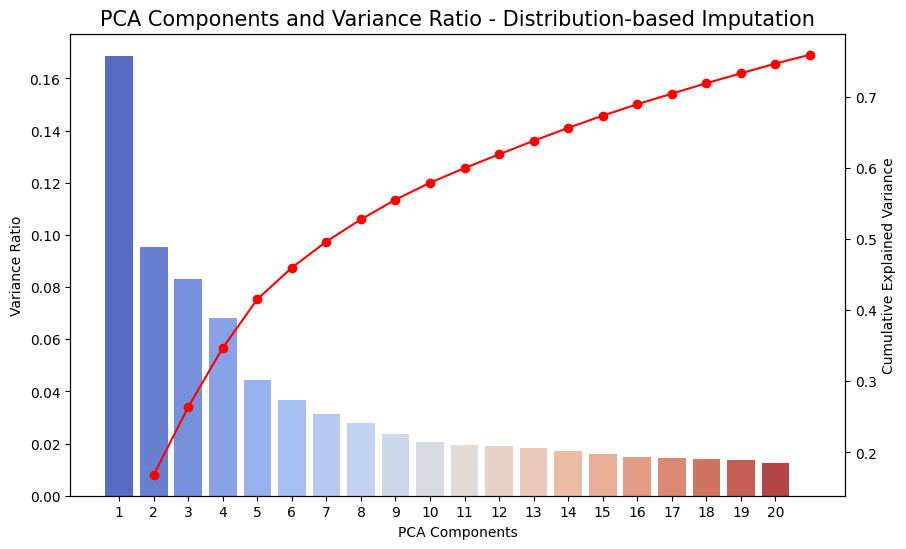

In [52]:
# Data Imputed with Strategy 1
fit_PCA(pca_imputed_strat1, strat_name = 'Distribution-based Imputation', n_components=20)

In [ ]:
# Data Imputed with Strategy 2
# fit_PCA(pca_imputed_strat2, strat_name = 'Auto-encoder Imputation', n_components=20)

## Data Insights

### Property Value vs. Pro. Age


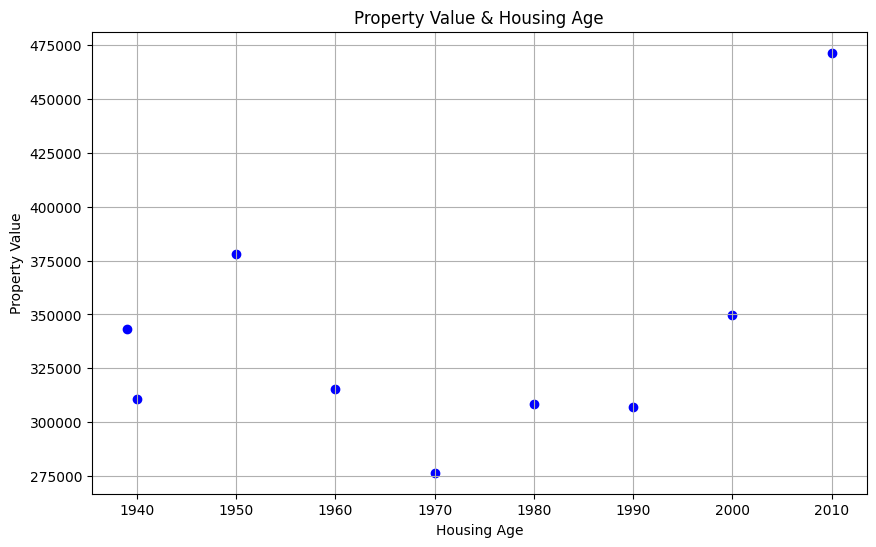

In [ ]:
# VALP & YRBLT
valp_col = np.mean(hp_21_base['VALP'])
yrblt_col = np.mean(hp_21_base['YRBLT'])

grouped_means = hp_21_base.groupby('YRBLT')['VALP'].mean()

plt.figure(figsize=(10, 6))
plt.scatter(grouped_means.index, grouped_means.values, marker='o', linestyle='-', color='b')
plt.title('Property Value & Housing Age')
plt.xlabel('Housing Age')
plt.ylabel('Property Value')
plt.grid(True)
plt.show()

### Gross Rent Paid vs. ELEC, GASP and FULP (Utility Costs)

In [ ]:
grntp_col = hp_21_base['GRNTP']
fulp_col = hp_21_base['FULP']
elec_col = hp_21_base['ELEP']
gasp_col = hp_21_base['GASP']

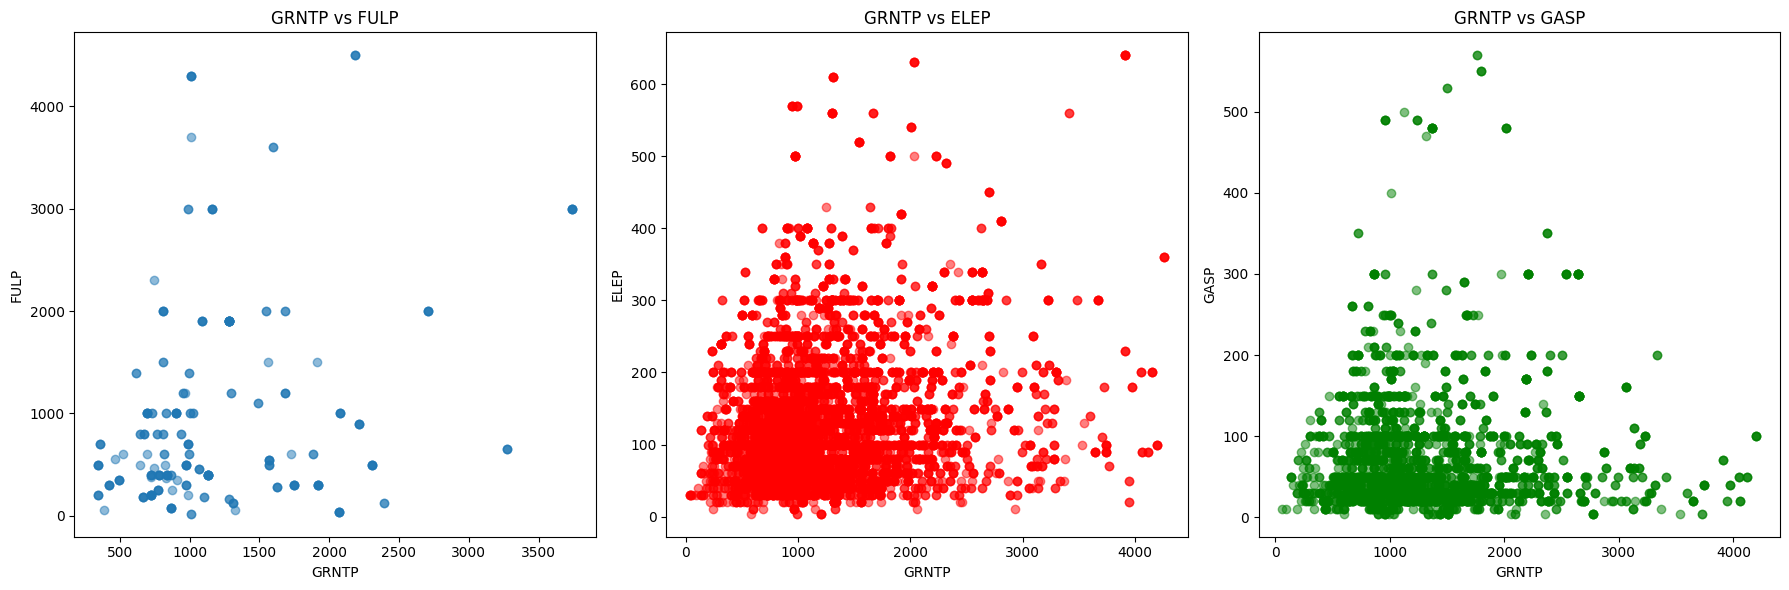

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns of plots

# GRNTP vs FULP
axs[0].scatter(hp_21_base['GRNTP'], hp_21_base['FULP'], alpha=0.5)
axs[0].set_title('GRNTP vs FULP')
axs[0].set_xlabel('GRNTP')
axs[0].set_ylabel('FULP')

# GRNTP vs ELEC
axs[1].scatter(hp_21_base['GRNTP'], hp_21_base['ELEP'], alpha=0.5, color='r')
axs[1].set_title('GRNTP vs ELEP')
axs[1].set_xlabel('GRNTP')
axs[1].set_ylabel('ELEP')

# GRNTP vs GASP
axs[2].scatter(hp_21_base['GRNTP'], hp_21_base['GASP'], alpha=0.5, color='g')
axs[2].set_title('GRNTP vs GASP')
axs[2].set_xlabel('GRNTP')
axs[2].set_ylabel('GASP')

plt.tight_layout()
plt.show()


### Employment vs. Economy


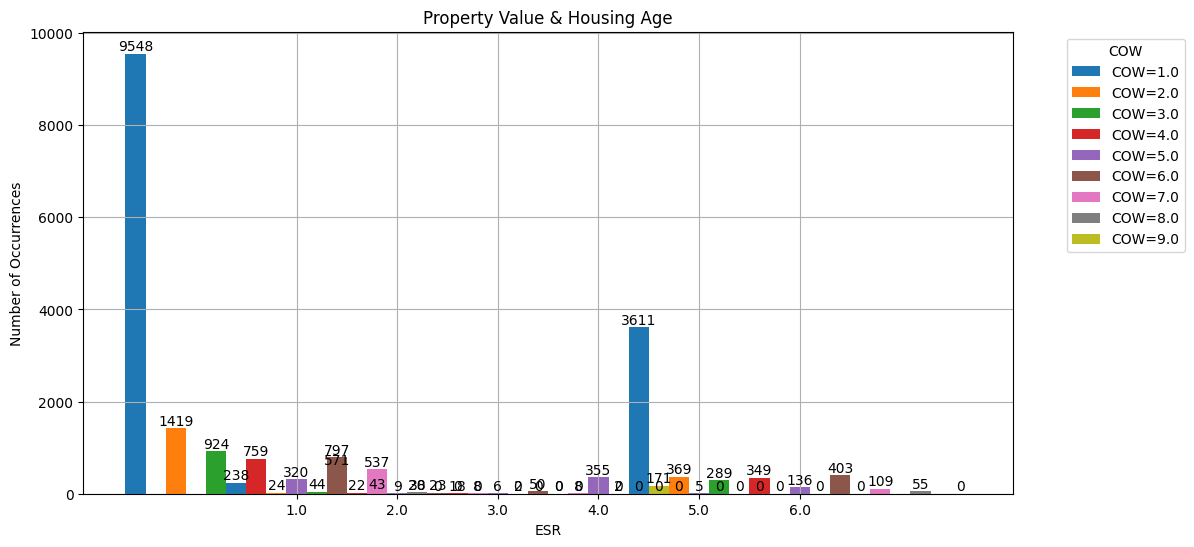

In [53]:
import numpy as np
import matplotlib.pyplot as plt

grouped_counts = hp_21_base.groupby('COW')['ESR'].value_counts().unstack().fillna(0)

fig, ax = plt.subplots(figsize=(12, 6))

# bar width
bar_width = 0.2
space_between_bars = 0.2

categories = grouped_counts.index
for i, category in enumerate(categories):
    bar_positions = np.arange(len(grouped_counts.columns)) + i * (bar_width + space_between_bars)
    bars = ax.bar(bar_positions, grouped_counts.loc[category], width=bar_width, label=f'COW={category}')

    # adding labels
    for bar, value in zip(bars, grouped_counts.loc[category]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(value)), ha='center', va='bottom')

ax.set_title('Property Value & Housing Age')
ax.set_xlabel('ESR')
ax.set_ylabel('Number of Occurrences')
ax.set_xticks(np.arange(len(grouped_counts.columns)) + (len(categories) - 1) * (bar_width + space_between_bars) / 2)
ax.set_xticklabels(grouped_counts.columns)
ax.legend(title='COW', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.show()


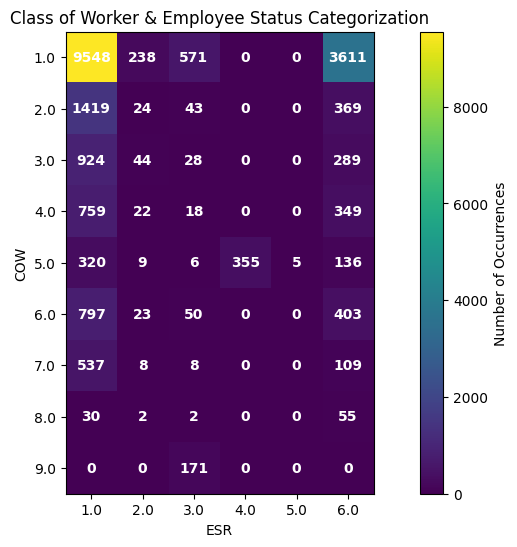

In [54]:
import numpy as np
import matplotlib.pyplot as plt

grouped_counts = hp_21_base.groupby('COW')['ESR'].value_counts().unstack().fillna(0)

fig, ax = plt.subplots(figsize=(12, 6))

im = ax.imshow(grouped_counts.values, cmap='viridis')

# show the values inside each cell
for i in range(len(grouped_counts.index)):
    for j in range(len(grouped_counts.columns)):
        ax.text(j, i, str(int(grouped_counts.iloc[i, j])),
                ha='center', va='center', color='w', fontweight='bold')

ax.set_xticks(np.arange(len(grouped_counts.columns)))
ax.set_yticks(np.arange(len(grouped_counts.index)))
ax.set_xticklabels(grouped_counts.columns)
ax.set_yticklabels(grouped_counts.index)
ax.set_xlabel('ESR')
ax.set_ylabel('COW')

# display
cbar = ax.figure.colorbar(im, ax=ax, cmap='viridis')
cbar.set_label('Number of Occurrences')

plt.title('Class of Worker & Employee Status Categorization')
plt.show()


# Regression Based Prediction Models

The dataframe utilized in this section will be obtained from the results of the PCA (named '**final_pp_df**'). Specifically, the feature space will be reduced to attributes which account for either the majority of the variance or deemed to be significant in the RE analysis -- determined by project requirements.


---


The following code snippet is a revised PCA function to return data based on the 'variance to be kept' threshold.

In [55]:
# fit_PCA(pca_imputed_strat1, strat_name = 'Distribution-based Imputation', n_components=20) (OLD)

def fit_PCA_revised(df, strat_name, n_components=0.70):
    model = PCA(n_components)
    data = df.to_numpy()
    model.fit(data)

    # transform data
    x_pca = model.transform(data)

    # creating the principal dataframe
    principalDf = pd.DataFrame(data=x_pca, columns=[f'PC{i+1}' for i in range(x_pca.shape[1])])

    components = model.components_
    feature_names = df.columns

    for i, component in enumerate(components[:len(model.explained_variance_ratio_)]):
        indices = np.argsort(np.abs(component))[::-1][:10]  # top 10 indices
        features = feature_names[indices]
        scores = component[indices]

        print(f"Principal Component {i+1}:")
        for feature, score in zip(features, scores):
            print(f"  {feature}: {score:.4f}")
        print()


    # ---- PLOTTING ----
    plt.figure(figsize=(10, 6))

    # bar plot for explained variance
    sns.barplot(x=np.arange(1, len(model.explained_variance_ratio_) + 1), y=model.explained_variance_ratio_, palette='coolwarm')

    plt.xlabel('PCA Components', fontsize=10)
    plt.ylabel('Variance Ratio', fontsize=10)
    plt.title(f'PCA Components and Variance Ratio - {strat_name}', fontsize=15)

    # cumulative sum line
    plt.twinx()
    plt.plot(np.arange(1, len(model.explained_variance_ratio_) + 1), np.cumsum(model.explained_variance_ratio_), color='red', marker='o')
    plt.ylabel('Cumulative Explained Variance', fontsize=10)

    plt.show()


    return principalDf

Principal Component 1:
  PERNP: 0.3774
  PINCP: 0.3725
  WAGP: 0.3724
  HINCP: 0.2932
  FINCP: 0.2508
  TAXAMT: 0.1741
  SMOCP: 0.1713
  VALP: 0.1495
  SCHL: 0.1480
  POVPIP_501.0: 0.1280

Principal Component 2:
  AGEP: -0.5473
  SCHL: -0.3716
  HHLDRAGEP: -0.3149
  MAR_5.0: 0.1852
  AGE_GROUP_HHLDRAGEP_60+: -0.1843
  AGE_GROUP_AGEP_60+: -0.1843
  AGE_GROUP_HHLDRAGEP_0-18: 0.1809
  AGE_GROUP_AGEP_0-18: 0.1809
  ESR_nan: 0.1653
  OC: 0.1588

Principal Component 3:
  ADJINC: -0.3187
  RMSP_nan: 0.2358
  YRBLT_nan: 0.2358
  BLD_nan: 0.2358
  BDSP_nan: 0.2358
  BDSP_nan: 0.2358
  HHL_nan: 0.2350
  HINCP: 0.2038
  POVPIP_nan: 0.1994
  HHL_1.0: -0.1941

Principal Component 4:
  HHLDRAGEP: 0.3110
  AGEP: 0.2647
  VALP: 0.2592
  TAXAMT: 0.2591
  WAGP: -0.2418
  SMOCP: 0.2341
  PERNP: -0.2307
  INSP: 0.2076
  FINCP: 0.1914
  COW_nan: 0.1791

Principal Component 5:
  SCHL: -0.4635
  VEH: -0.3361
  PINCP: 0.3032
  COW_nan: 0.2345
  PERNP: 0.2331
  WAGP: 0.2228
  COW_1.0: -0.1750
  ELEP: -0.1716
 

<ipython-input-55-8f7eb8da5624>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(1, len(model.explained_variance_ratio_) + 1), y=model.explained_variance_ratio_, palette='coolwarm')


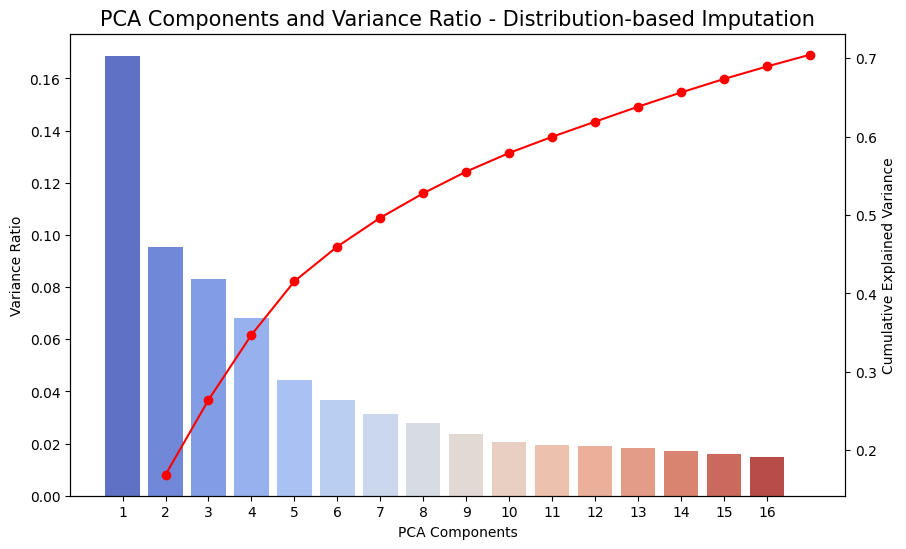

In [56]:
principal_df = fit_PCA_revised(pca_imputed_strat1, strat_name = 'Distribution-based Imputation', n_components = 0.70)

In [ ]:
principal_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
0,0.843117,-0.650394,-1.016047,-0.737679,-0.357860,-1.732906,-0.227765,0.390427,0.357161,-0.001414,-1.518521,-0.137490,0.691258,-0.112317,0.624966,0.139953
1,0.861127,-0.615889,-0.658804,1.843229,-1.024672,-0.008957,0.798657,-1.422988,0.613704,-1.196924,-0.504782,0.012638,-0.458621,-0.052569,0.025286,-0.148264
2,4.157252,-0.970400,0.897278,-0.672099,0.127498,-0.304573,0.487657,-1.475460,-0.089160,0.188438,-0.407277,-0.393219,-2.123228,-0.695951,-0.441515,2.069057
3,-1.066810,-1.276562,-1.804230,-0.593413,-0.677222,-1.169728,0.523601,0.070745,-0.404856,2.329280,-0.596047,-0.639357,0.080714,1.650442,-0.436326,1.373684
4,-1.582719,-0.302935,-1.190328,-0.373207,0.081931,-0.951350,0.320534,-0.441005,-1.399274,0.521812,0.073041,-0.817956,0.973478,0.432225,0.363847,-0.178613


### Feature Space Reduction Results & Justification/Explanation(s)


```
PERNP (Personal Income): Frequently appears with significant weights. Income levels are directly correlated with housing affordability and choices.

PINCP (Total Personal Income): Similar to PERNP, it's crucial for understanding individual or household economic status.

WAGP (Wages or Salary Income): Another indicator of economic status, affecting housing affordability.

HINCP (Household Income): Directly impacts the type and value of housing that households can afford.

FINCP (Family Income): Influences the purchasing power of families for real estate.

TAXAMT (Property Taxes): Reflects property values and is directly related to real estate valuation.

SMOCP (Selected Monthly Owner Costs): Important for understanding the monthly financial commitments associated with homeownership, which can affect property value.

SCHL (Educational Attainment): Education level can correlate with income potential and housing choices.

AGEP (Age): Age can influence income levels, life stage, housing needs, and preferences.

VEH (Number of Vehicles): Reflects a household's wealth and potentially the value of their home.

ELEP (Electricity Monthly Cost): Can indicate the size and value of a property based on energy consumption.

MRGP (Mortgage Payment): Directly related to home value and financing.

INDP (Industry of Employment): Some industries pay higher wages, which could correlate with higher home values.

WKHP (Hours Worked Per Week): Can indicate earning potential and economic status, affecting housing choices.

GASP (Gas Monthly Cost): Like electricity costs, can reflect property size and value.

INSP (Insurance Cost): Directly related to property value and homeowner costs.

MAR_5.0 (Marital Status): Can indicate household size and stability, affecting housing needs.

HHLDRAGEP (Age of Household Holder): Can indicate stage of life, influencing housing preferences and values.

SEX (Sex of the Individual): While not directly related to property value, demographic factors can influence housing trends in certain areas.

GRNTP (Gross Rent): For rental properties, this can directly indicate property value.
```



In [57]:
selected_attrs = ['PERNP', 'PINCP', 'WAGP', 'HINCP', 'FINCP', 'TAXAMT', 'SMOCP',
                  'SCHL', 'AGEP', 'VEH', 'ELEP', 'MRGP', 'INDP', 'WKHP', 'GASP',
                  'INSP', 'MAR_5.0', 'HHLDRAGEP', 'SEX', 'GRNTP','VALP']
# reduce df
final_pp_df = pca_imputed_strat1[selected_attrs]

In [58]:
final_pp_df.head()

,PERNP,PINCP,WAGP,HINCP,FINCP,TAXAMT,SMOCP,SCHL,AGEP,VEH,...,MRGP,INDP,WKHP,GASP,INSP,MAR_5.0,HHLDRAGEP,SEX,GRNTP,VALP
0,0.007188,-0.084873,0.042500,0.276988,0.227660,-0.933595,-0.539326,-0.049322,0.686431,-0.145945,...,-0.943472,-0.584974,4.379785e-01,-0.082487,-1.026544,0.0,0.416019,0.0,-0.218293,-0.745801
1,-0.466586,-0.570661,-0.456582,0.497771,0.444950,0.346676,0.569164,0.915848,0.728160,0.698099,...,0.546307,1.292547,3.109766e-17,-0.454159,-0.287382,0.0,0.292808,1.0,-0.218293,0.044331
2,2.376060,2.059959,2.537912,0.497771,0.444950,0.346676,0.569164,1.108881,0.602972,0.698099,...,0.546307,1.167353,-2.485832e+00,-0.454159,-0.287382,0.0,0.292808,0.0,-0.218293,0.044331
3,-0.383202,-0.493496,-0.368744,-0.934840,-0.964999,-0.892951,-0.976549,-0.628423,0.769889,-0.145945,...,-0.188092,-0.733309,-2.276988e+00,-0.330269,-1.030259,0.0,0.539230,1.0,-0.218293,-0.646582
4,-0.466586,-0.554878,-0.456582,-0.934840,-0.964999,-0.892951,-0.976549,-0.049322,-0.106428,-0.145945,...,-0.188092,0.408606,3.109766e-17,-0.330269,-1.030259,1.0,0.539230,1.0,-0.218293,-0.646582


### Baseline Linear Regression Model

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def linear_regression_with_rmse(df, target_feature_name):
    # separate features and target variable
    X = df.drop(target_feature_name, axis=1)
    y = df[target_feature_name]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    # fit
    model = LinearRegression()
    model.fit(X_train, y_train)

    # predict
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # error calculations
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

    # --- PLOTTING ---
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(1)
    plt.bar(index, rmse_train, bar_width, label='Training RMSE')
    plt.bar(index + bar_width, rmse_val, bar_width, label='Validation RMSE')

    plt.xlabel('Model')
    plt.ylabel('RMSE')
    plt.title('Training vs Validation RMSE')
    plt.xticks(index + bar_width / 2, ['Linear Regression'])
    plt.legend()
    plt.tight_layout()
    plt.show()

    print('RMSE_TRAIN:',rmse_train)
    print('RMSE_VAL:',rmse_val)
    return model

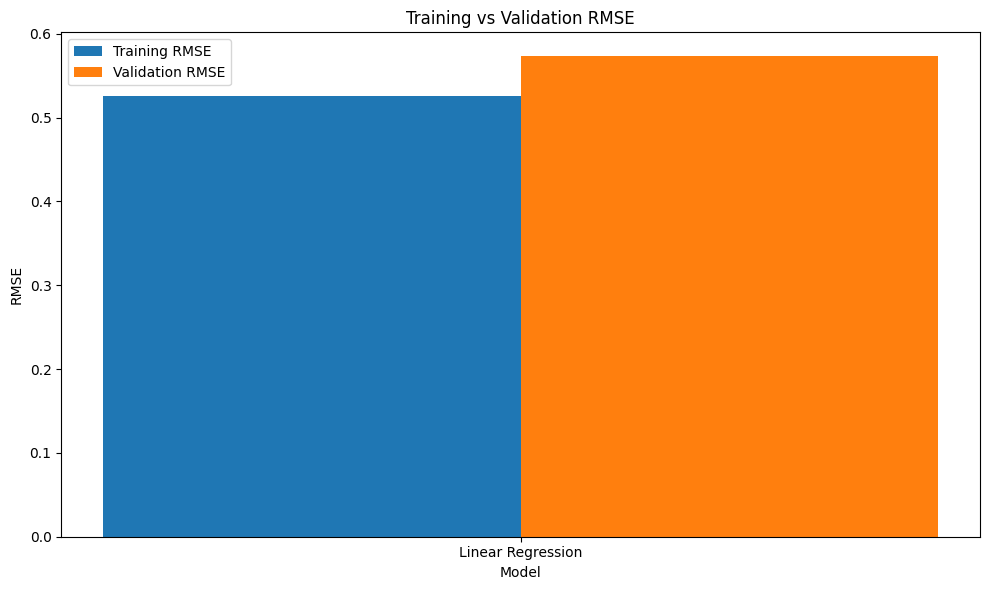

RMSE_TRAIN: 0.5256525176618833
RMSE_VAL: 0.5729664702253504

Feature Coefficients:
PERNP: -0.028754777186602375
PINCP: 0.08886441598969158
WAGP: -0.06301990309891169
HINCP: 0.05727204802802177
FINCP: 0.07562656267516699
TAXAMT: 0.2904414228823954
SMOCP: 0.18000699509238682
SCHL: 0.007714686720020255
AGEP: 0.00041958624178186314
VEH: -0.025775620875511395
ELEP: 0.011629374951361238
MRGP: 0.11725669978953372
INDP: 0.0021098209004404103
WKHP: -0.00824093092743186
GASP: -0.016835814923815674
INSP: 0.10973611425242513
MAR_5.0: 0.0028999440491896313
HHLDRAGEP: 0.038814494423154995
SEX: 0.0014764317975909423
GRNTP: -0.019363896232502054


In [60]:
lin_model = linear_regression_with_rmse(final_pp_df, 'VALP')
feature_names = final_pp_df.columns

coefficients = lin_model.coef_
print()
print("Feature Coefficients:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

**Comments**


---




```
TAXAMT (0.2904414228823954): This has the highest positive coefficient, suggesting a strong positive relationship with the target variable. Higher property taxes are likely associated with higher property values.

SMOCP (0.18000699509238682): Another significant positive coefficient, indicating that higher selected monthly owner costs contribute positively to the target's value. This is logical, as more valuable properties tend to have higher associated costs.

MRGP (0.11725669978953372): This indicates that higher mortgage payments are associated with higher property values, which aligns with expectations since more expensive homes typically come with larger mortgages.

INSP (0.10973611425242513): Indicates a positive relationship between insurance costs and the target variable, suggesting that higher insurance costs (possibly due to higher property value) positively affect the target variable.

PINCP (0.08886441598969158) and FINCP (0.07562656267516699): These coefficients suggest that higher personal and family income levels are positively associated with the target variable, possibly indicating that higher-income individuals or families can afford more valuable properties.

HINCP (0.05727204802802177): Similarly, higher household incomes are positively associated with the target variable, reinforcing the relationship between income and property value.

Negative Coefficients (e.g., PERNP: -0.028754777186602375, WAGP: -0.06301990309891169): These suggest that, all else being equal, higher values of these features might be associated with lower values of the target variable. For example, higher wages (WAGP) negatively influencing the target might seem counterintuitive. This could be a result of multicollinearity or other complex interactions in the dataset that aren't directly observable.

Small or Close to Zero Coefficients (e.g., AGEP: 0.00041958624178186314, SEX: 0.0014764317975909423): Features with coefficients close to zero have a negligible linear effect on the target variable. This does not mean they are unimportant but rather that their linear contribution, after accounting for other features, is minimal in this model.
```

The model is currently not susceptible to overfitting, but the coefficients reveal that non-linear relationships within the data are likely not captured to their full essence.

## Attempt at Capturing Non-Linearity: Boosted Regression Trees




In [61]:
!pip install xgboost

In [62]:
from xgboost import XGBRegressor

def xgboost_regression_with_rmse(df, target_feature_name):
    X = df.drop(target_feature_name, axis=1)
    y = df[target_feature_name]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    model = XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

    # --- PLOTTING ---
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(1)
    plt.bar(index, rmse_train, bar_width, label='Training RMSE')
    plt.bar(index + bar_width, rmse_val, bar_width, label='Validation RMSE')

    plt.xlabel('Model')
    plt.ylabel('RMSE')
    plt.title('Training vs Validation RMSE - XGBoost')
    plt.xticks(index + bar_width / 2, ['XGBoost'])
    plt.legend()
    plt.tight_layout()
    plt.show()

    print('RMSE_TRAIN:',rmse_train)
    print('RMSE_VAL:',rmse_val)
    return model

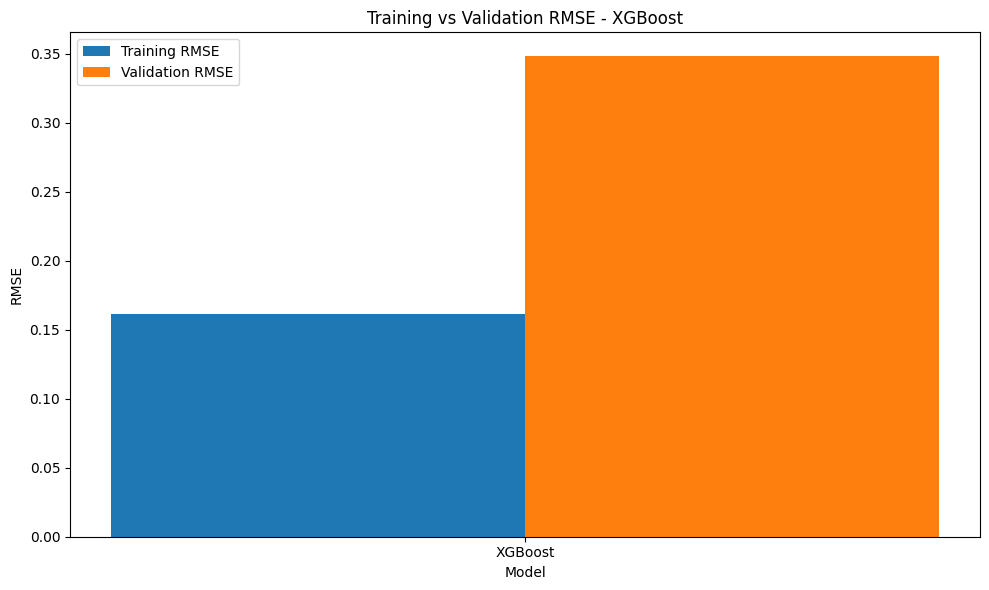

RMSE_TRAIN: 0.16125253477722035
RMSE_VAL: 0.34807377032435255


In [64]:
xgboost_model = xgboost_regression_with_rmse(final_pp_df, 'VALP') # likely to be overfitting in baseline BRT model

In [65]:
# fitting function edited to allow for hyperparameter tuning
import xgboost as xgb
def fit_xgboost_with_params(df, target_feature_name, max_depth=6, n_estimators=100, reg_lambda=1, reg_alpha=0, lr = 0.1):
    X = df.drop(target_feature_name, axis=1)
    y = df[target_feature_name]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    xgb_model = xgb.XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, reg_lambda=reg_lambda, reg_alpha=reg_alpha, random_state=42, learning_rate = lr)

    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)

    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(['Training RMSE', 'Validation RMSE'], [rmse_train, rmse_val], color=['blue', 'orange'])
    plt.title('Training vs Validation RMSE')
    plt.ylabel('RMSE')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')
    plt.show()

    print('RMSE_TRAIN:',rmse_train)
    print('RMSE_VAL:',rmse_val)
    return xgb_model

#### Hyperparameter Tuning

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


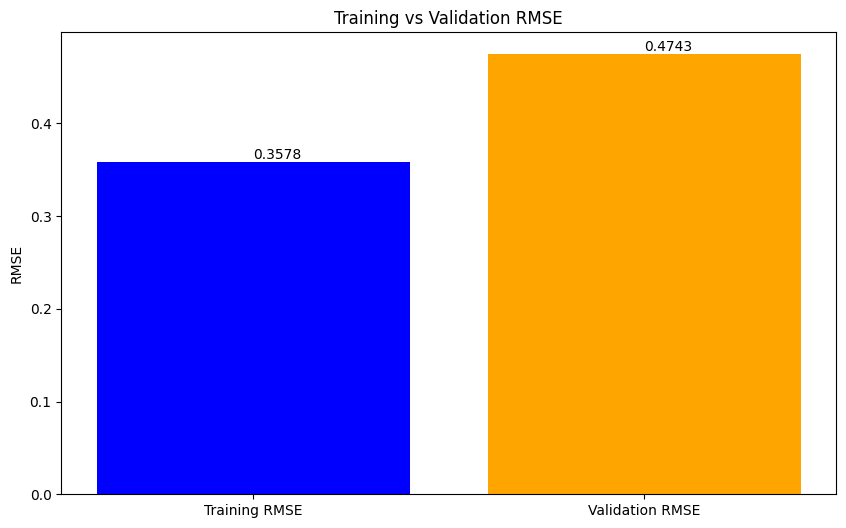

RMSE_TRAIN: 0.35775988126229114
RMSE_VAL: 0.4743112763736403


In [66]:
model_set1 = fit_xgboost_with_params(final_pp_df, 'VALP', max_depth=4, n_estimators=100, reg_lambda=1, reg_alpha=0) # conservative approach

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


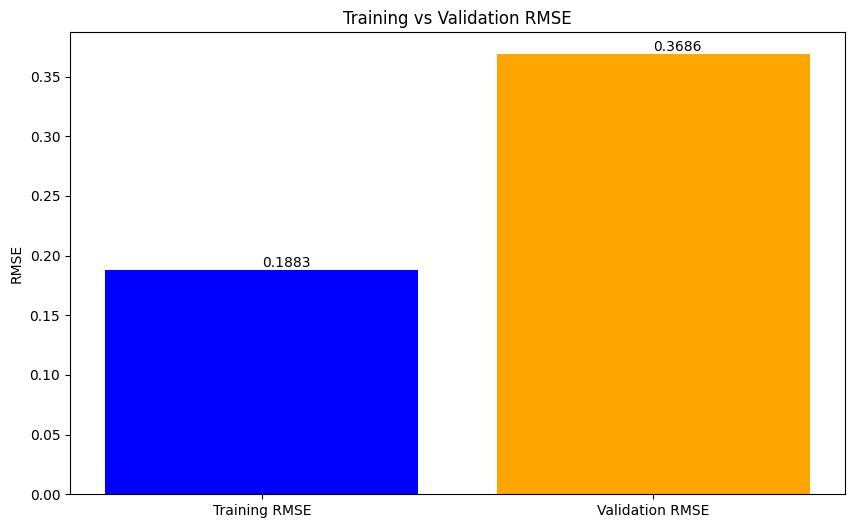

RMSE_TRAIN: 0.18827612277539182
RMSE_VAL: 0.36863908493911746


In [67]:
model_set2 = fit_xgboost_with_params(final_pp_df, 'VALP', max_depth=6, n_estimators=200, reg_lambda=0.5, reg_alpha=0.5) # increased complexity

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


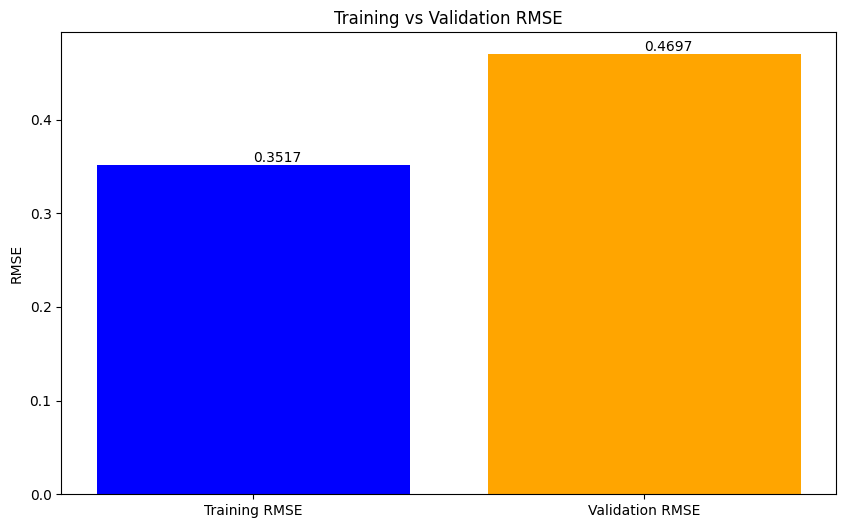

RMSE_TRAIN: 0.3517017671504158
RMSE_VAL: 0.4697022344685355


In [68]:
model_set3 = fit_xgboost_with_params(final_pp_df, 'VALP', max_depth=3, n_estimators=300, reg_lambda=2, reg_alpha=1) # high regularization

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


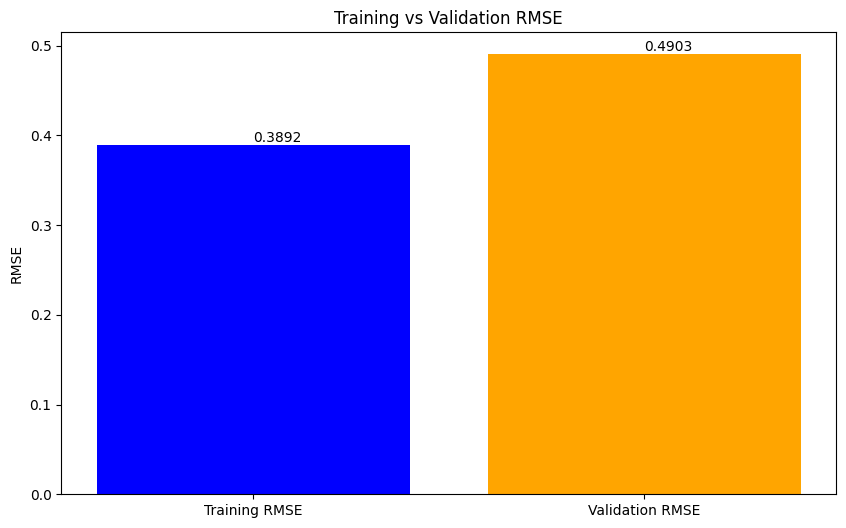

RMSE_TRAIN: 0.38916661224566207
RMSE_VAL: 0.4902557355154592


In [69]:
model_set4 = fit_xgboost_with_params(final_pp_df, 'VALP', max_depth=5, n_estimators=150, reg_lambda=1, reg_alpha=2, lr = 0.02) # balanced approach, encouraging sparsity

**Comments**


---


* Model 4, with a configuration of max_depth=5, n_estimators=150, reg_lambda=1, reg_alpha=2, and a learning rate (lr) of 0.02, presents an interesting case when compared against the previous models (1-3) with varying hyperparameters. It achieved an RMSE_TRAIN of 0.3892 and RMSE_VAL of 0.4903. Model 4 is determined to be a good middle-ground in terms of performance and minimizing the possibility of overfitting. Further comments below.

* Comparatively, Model 3 demonstrated better generalization from training to validation despite its higher complexity (max_depth=3, n_estimators=300, reg_lambda=2, reg_alpha=1), achieving lower RMSE scores in both training and validation phases. This suggests that higher regularization and a larger number of estimators might be beneficial for this dataset.

* Model 2 exhibited the best generalization capability among all models tested, with significantly lower RMSE_TRAIN and RMSE_VAL scores (max_depth=6, n_estimators=200, reg_lambda=0.5, reg_alpha=0.5). This indicates that a balanced approach to both regularization and model complexity, along with a possibly higher learning rate, could yield the most optimal results for this specific dataset.

* Model 1, with its simpler setup (max_depth=4, n_estimators=100, reg_lambda=1, reg_alpha=0), performed comparably to Model 4 but with slightly worse validation RMSE. This similarity in performance suggests that slight increases in model complexity and adjustments to hyperparameters (as in Model 4) can enhance model fit without drastically affecting generalization, as observed in the marginal improvement from Model 1 to Model 4.


In [70]:
!pip install graphviz

<Figure size 1e+07x6e+06 with 0 Axes>

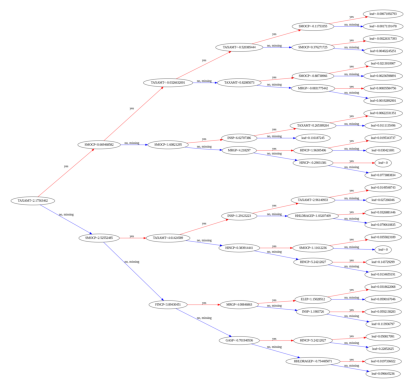

In [ ]:
# visualizing leaf nodes and branching decisions within model 4
tree_to_plot = 0
plt.figure(figsize=(100000, 60000))
xgb.plot_tree(model_set4, num_trees=tree_to_plot, rankdir='LR')
plt.show()
plt.savefig('tree_high_res.png', dpi=300)  # Adjust DPI as needed
plt.close()

In [ ]:
# save the sample tree locally for inspection if needed below
'''
tree_to_plot = 0
xgb.to_graphviz(model_set4, num_trees=tree_to_plot, rankdir='LR', format='dot').render('tree_visualization')
'''

'tree_visualization.pdf'

# Neural Network Based Prediction Models

In [71]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

def train_and_plot_nn(df, target_column='VALP', epochs=100, batch_size=32, hidden_layers=2, neurons=64, learning_rate=0.001, l1_reg=0.001, l2_reg=0.001):
    X = df.drop(columns=[target_column]).copy()
    y = df[target_column].values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    # scaling just in case, safety net
    scaler = StandardScaler()
    continuous_columns = X_train.select_dtypes(include=['float64', 'int']).columns
    X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
    X_val[continuous_columns] = scaler.transform(X_val[continuous_columns])

    # NN Architecture
    model = Sequential()
    # input layer
    model.add(Dense(neurons, activation='relu', input_dim=X_train.shape[1],
                    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    # hidden layers
    for _ in range(hidden_layers - 1):  # subtracting 1 because we already have the input layer
        model.add(Dense(neurons, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    # output layer for regression
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    # ---Training---
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=1,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

    # ---Plotting---
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # RMSE values
    axs[0].plot(history.history['rmse'], label='Training RMSE')
    axs[0].plot(history.history['val_rmse'], label='Validation RMSE')
    axs[0].set_title('Model RMSE')
    axs[0].set_ylabel('RMSE')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    # training & validation loss values
    axs[1].plot(history.history['loss'], label='Training Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()

    return model

Epoch 1/100
846/846 [==============================] - 9s 9ms/step - loss: 0.6992 - rmse: 0.5369 - val_loss: 0.5612 - val_rmse: 0.5682
Epoch 2/100
846/846 [==============================] - 2s 3ms/step - loss: 0.4352 - rmse: 0.5169 - val_loss: 0.4442 - val_rmse: 0.5697
Epoch 3/100
846/846 [==============================] - 2s 3ms/step - loss: 0.3551 - rmse: 0.5121 - val_loss: 0.3868 - val_rmse: 0.5598
Epoch 4/100
846/846 [==============================] - 2s 2ms/step - loss: 0.3203 - rmse: 0.5084 - val_loss: 0.3618 - val_rmse: 0.5571
Epoch 5/100
846/846 [==============================] - 3s 3ms/step - loss: 0.3041 - rmse: 0.5091 - val_loss: 0.3547 - val_rmse: 0.5598
Epoch 6/100
846/846 [==============================] - 3s 3ms/step - loss: 0.2927 - rmse: 0.5066 - val_loss: 0.3365 - val_rmse: 0.5504
Epoch 7/100
846/846 [==============================] - 2s 3ms/step - loss: 0.2861 - rmse: 0.5052 - val_loss: 0.3367 - val_rmse: 0.5555
Epoch 8/100
846/846 [==============================] - 

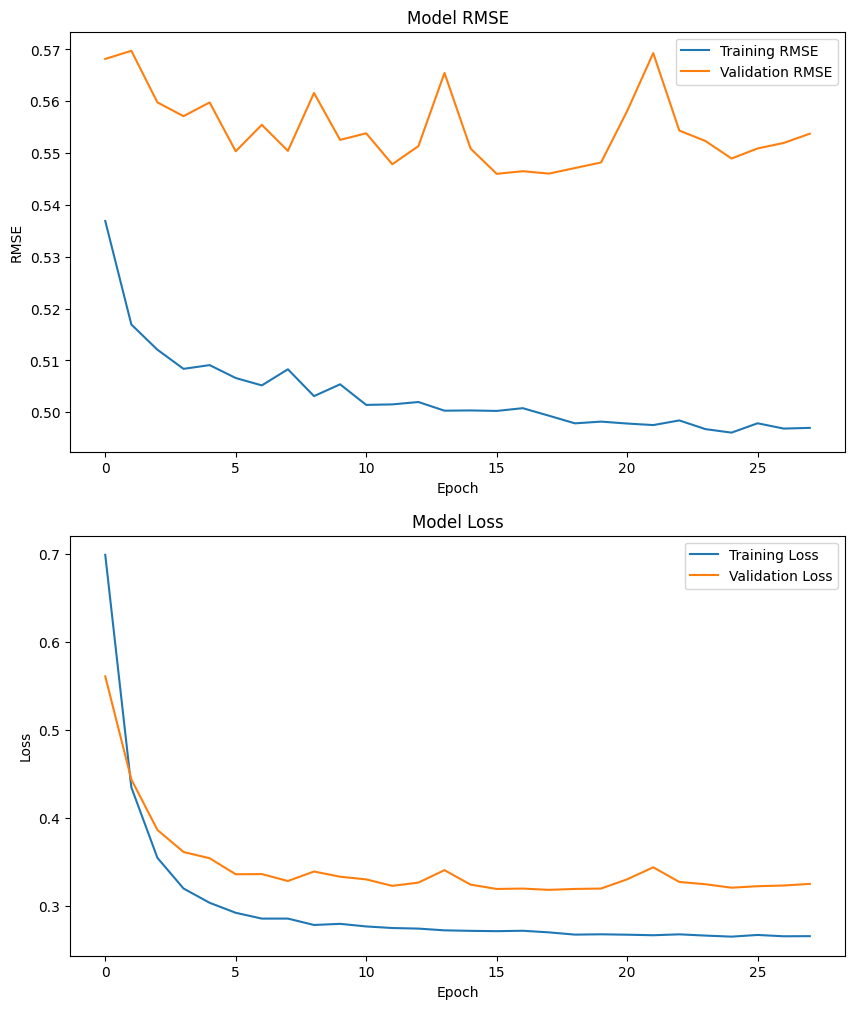

In [72]:
baseline_nn = train_and_plot_nn(final_pp_df, target_column='VALP', epochs=100, batch_size=32)

## Hyperparameter Tuning

Epoch 1/100
1691/1691 [==============================] - 6s 3ms/step - loss: 0.3418 - rmse: 0.5528 - val_loss: 0.3344 - val_rmse: 0.5653
Epoch 2/100
1691/1691 [==============================] - 5s 3ms/step - loss: 0.2949 - rmse: 0.5292 - val_loss: 0.3273 - val_rmse: 0.5618
Epoch 3/100
1691/1691 [==============================] - 4s 2ms/step - loss: 0.2896 - rmse: 0.5253 - val_loss: 0.3669 - val_rmse: 0.5940
Epoch 4/100
1691/1691 [==============================] - 4s 2ms/step - loss: 0.2892 - rmse: 0.5264 - val_loss: 0.3500 - val_rmse: 0.5832
Epoch 5/100
1691/1691 [==============================] - 5s 3ms/step - loss: 0.2871 - rmse: 0.5264 - val_loss: 0.3598 - val_rmse: 0.5910
Epoch 6/100
1691/1691 [==============================] - 4s 2ms/step - loss: 0.2911 - rmse: 0.5309 - val_loss: 0.3264 - val_rmse: 0.5631
Epoch 7/100
1691/1691 [==============================] - 4s 2ms/step - loss: 0.2839 - rmse: 0.5238 - val_loss: 0.3255 - val_rmse: 0.5623
Epoch 8/100
1691/1691 [==================

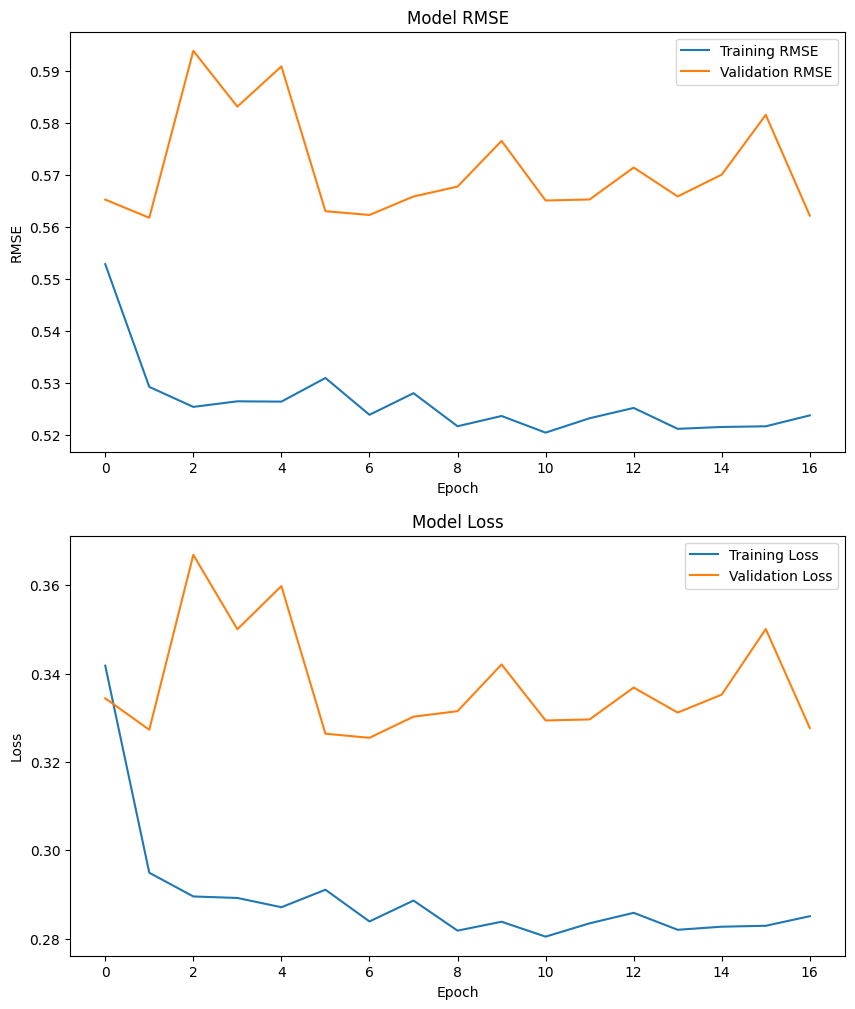

In [73]:
# model 1 - reduced model complexity
nn_model1 = train_and_plot_nn(
    df=final_pp_df,
    target_column='VALP',
    epochs=100, batch_size=16, hidden_layers=1, neurons=32, learning_rate=0.01,
    l1_reg=0.001, l2_reg=0.001
)

Epoch 1/200
423/423 [==============================] - 5s 9ms/step - loss: 0.4371 - rmse: 0.5659 - val_loss: 0.3822 - val_rmse: 0.5807
Epoch 2/200
423/423 [==============================] - 1s 3ms/step - loss: 0.3259 - rmse: 0.5416 - val_loss: 0.3537 - val_rmse: 0.5740
Epoch 3/200
423/423 [==============================] - 1s 3ms/step - loss: 0.2947 - rmse: 0.5246 - val_loss: 0.3317 - val_rmse: 0.5614
Epoch 4/200
423/423 [==============================] - 1s 3ms/step - loss: 0.2906 - rmse: 0.5234 - val_loss: 0.3383 - val_rmse: 0.5663
Epoch 5/200
423/423 [==============================] - 1s 3ms/step - loss: 0.2789 - rmse: 0.5123 - val_loss: 0.3260 - val_rmse: 0.5578
Epoch 6/200
423/423 [==============================] - 2s 4ms/step - loss: 0.2811 - rmse: 0.5166 - val_loss: 0.3393 - val_rmse: 0.5706
Epoch 7/200
423/423 [==============================] - 2s 6ms/step - loss: 0.2828 - rmse: 0.5188 - val_loss: 0.3273 - val_rmse: 0.5581
Epoch 8/200
423/423 [==============================] - 

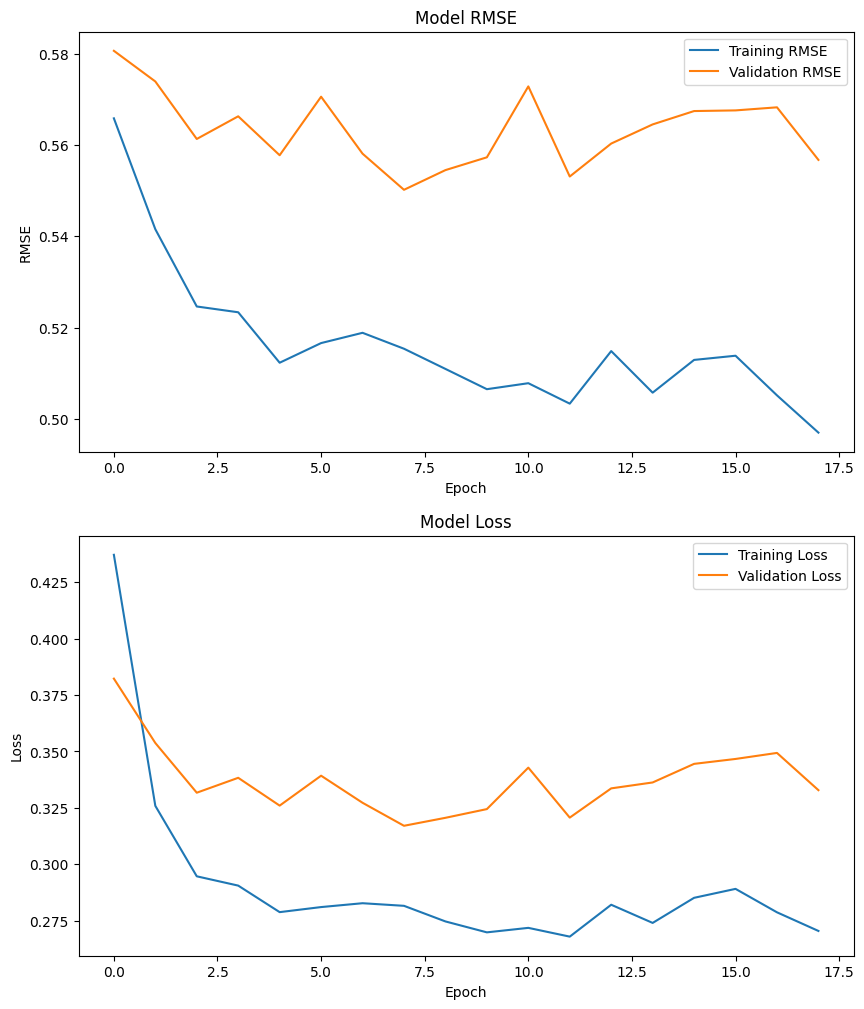

In [74]:
# model 2 - increased model capacity and learning rate
nn_model1 = train_and_plot_nn(
    df=final_pp_df,
    target_column='VALP',
    epochs=200, batch_size=64, hidden_layers=3, neurons=128, learning_rate=0.01, l1_reg=0.0001, l2_reg=0.0001
)

**IMPORTANT:** from model 3 and onwards the training and testing split in the data was adjusted from 80-20 to 70-30!

Epoch 1/100
846/846 [==============================] - 7s 7ms/step - loss: 0.5593 - rmse: 0.5474 - val_loss: 0.4833 - val_rmse: 0.5715
Epoch 2/100
846/846 [==============================] - 2s 3ms/step - loss: 0.3875 - rmse: 0.5232 - val_loss: 0.4110 - val_rmse: 0.5720
Epoch 3/100
846/846 [==============================] - 2s 2ms/step - loss: 0.3384 - rmse: 0.5187 - val_loss: 0.3746 - val_rmse: 0.5622
Epoch 4/100
846/846 [==============================] - 2s 2ms/step - loss: 0.3171 - rmse: 0.5163 - val_loss: 0.3592 - val_rmse: 0.5601
Epoch 5/100
846/846 [==============================] - 2s 2ms/step - loss: 0.3069 - rmse: 0.5160 - val_loss: 0.3508 - val_rmse: 0.5609
Epoch 6/100
846/846 [==============================] - 2s 3ms/step - loss: 0.2992 - rmse: 0.5149 - val_loss: 0.3475 - val_rmse: 0.5620
Epoch 7/100
846/846 [==============================] - 4s 4ms/step - loss: 0.2941 - rmse: 0.5135 - val_loss: 0.3432 - val_rmse: 0.5605
Epoch 8/100
846/846 [==============================] - 

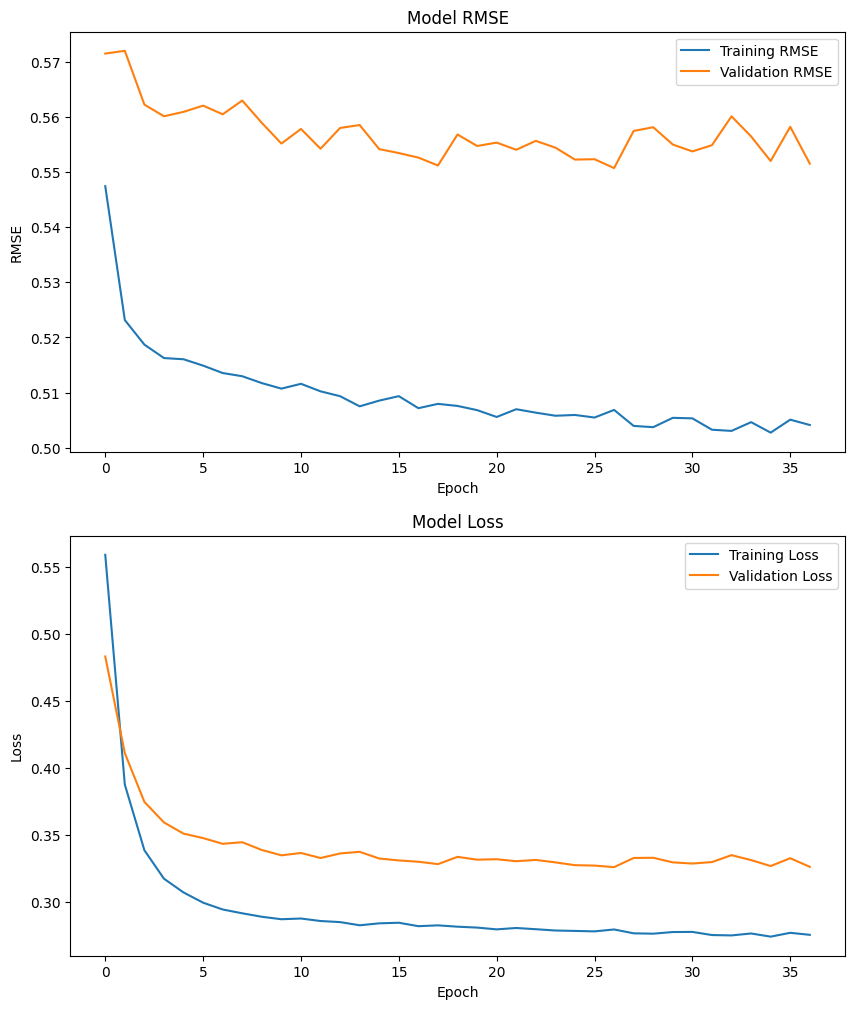

In [75]:
# model 3 - increased penalty and conservative complexity
nn_model1 = train_and_plot_nn(
    df=final_pp_df,
    target_column='VALP',
    epochs=100, batch_size=32, hidden_layers=3, neurons=16, learning_rate=0.001,
    l1_reg=0.001, l2_reg=0.005
)

Epoch 1/100
846/846 [==============================] - 6s 5ms/step - loss: 0.5388 - rmse: 0.5412 - val_loss: 0.4862 - val_rmse: 0.5975
Epoch 2/100
846/846 [==============================] - 2s 2ms/step - loss: 0.3651 - rmse: 0.5231 - val_loss: 0.3777 - val_rmse: 0.5583
Epoch 3/100
846/846 [==============================] - 2s 3ms/step - loss: 0.3216 - rmse: 0.5179 - val_loss: 0.3808 - val_rmse: 0.5795
Epoch 4/100
846/846 [==============================] - 4s 4ms/step - loss: 0.3048 - rmse: 0.5158 - val_loss: 0.3441 - val_rmse: 0.5565
Epoch 5/100
846/846 [==============================] - 2s 3ms/step - loss: 0.2964 - rmse: 0.5136 - val_loss: 0.3376 - val_rmse: 0.5540
Epoch 6/100
846/846 [==============================] - 2s 3ms/step - loss: 0.2910 - rmse: 0.5115 - val_loss: 0.3491 - val_rmse: 0.5658
Epoch 7/100
846/846 [==============================] - 2s 2ms/step - loss: 0.2867 - rmse: 0.5092 - val_loss: 0.3296 - val_rmse: 0.5517
Epoch 8/100
846/846 [==============================] - 

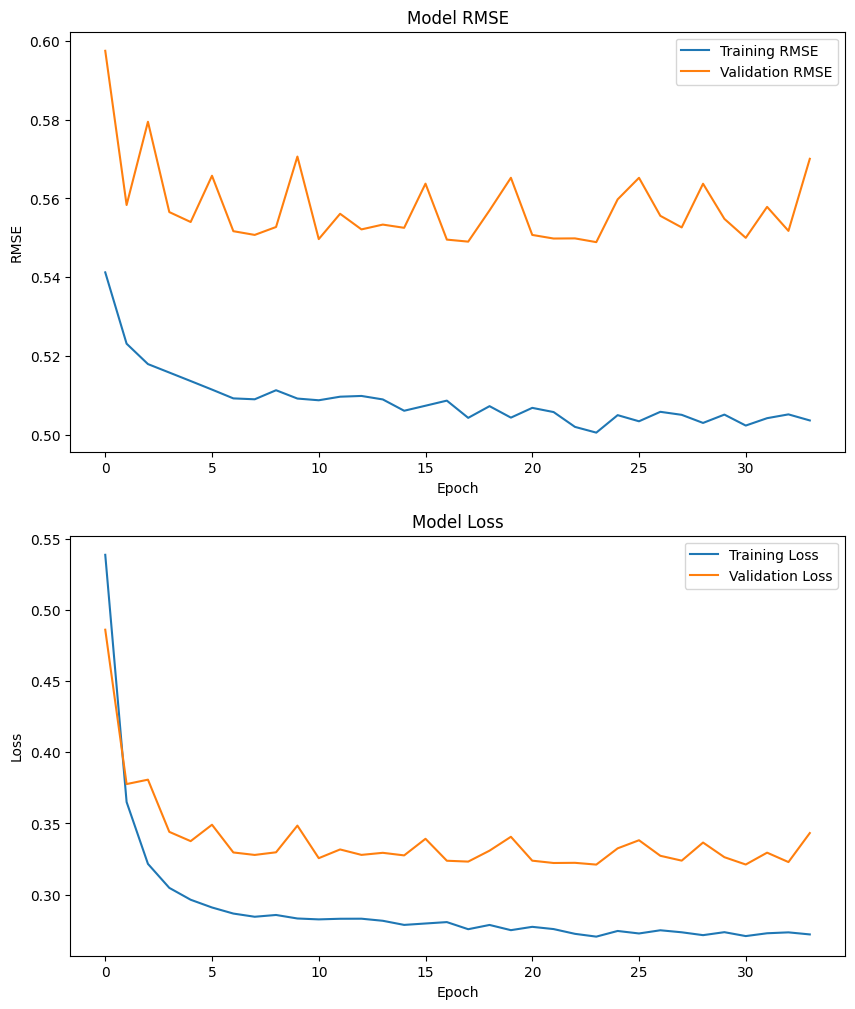

In [76]:
# model 4 - balanced shot at increased model complexity, less penalization and bump up in lr
nn_model1 = train_and_plot_nn(
    df=final_pp_df,
    target_column='VALP',
    epochs=100, batch_size=32, hidden_layers=4, neurons=32, learning_rate=0.002,
    l1_reg=0.0005, l2_reg=0.002
)

**Comments**


---
In comparing the performance of neural networks to that of boosted regression trees on the task of predicting property values (VALP), it appears that the neural network models were not as successful. Throughout the various iterations and hyperparameter tunings attempted with the neural networks, I observed a consistent pattern where the training RMSE would generally decrease, indicating effective learning from the training data. However, the validation RMSE remained volatile and did not show a consistent downward trend, often plateauing or even increasing after certain epochs. This pattern suggests to me that while the neural networks were capable of fitting to the training data, they struggled to generalize those patterns to the validation set.



# Clustering - Finding Regions w/ Similar RE Markets

In [ ]:
# include 'Division_Name','Region_Name','PUMA_DESC' back into final_pp_df from hp_21_base prior to clustering

## Number of Clusters, How to Choose?

In [78]:
from sklearn.cluster import KMeans

def kmeans_elbow_method(df, max_clusters):
    wcss = []

    # testing numbers of clusters
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)

    # --- Plotting ---
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')  # tithin cluster sum of squares (WCSS)
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

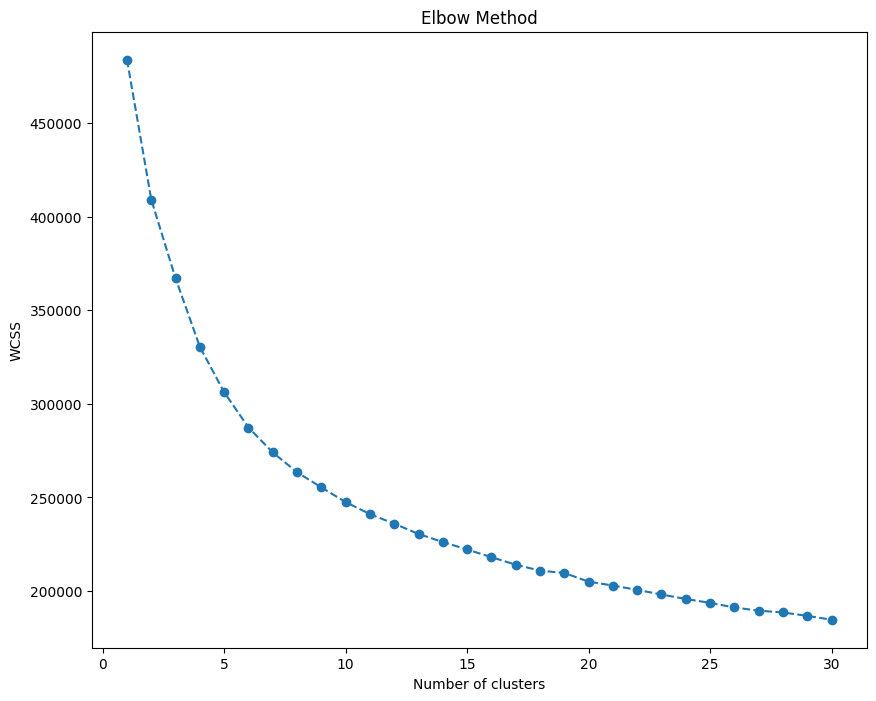

In [79]:
kmeans_elbow_method(final_pp_df, 30)

Appropriate to have a cutoff at 20 clusters.

## Clustering (All Attributes Inclusive)

In [80]:
final_pp_df = pca_imputed_strat1[selected_attrs]

In [81]:
# taking mean for all data grouped by PUMA_DESC
cluster_pp_df = final_pp_df.merge(hp_21_base[['PUMA_DESC']],
                                left_index=True, right_index=True, how='left')
cluster_pp_df = cluster_pp_df.groupby('PUMA_DESC').mean().reset_index()

In [82]:
cluster_pp_df[cluster_pp_df['PUMA_DESC']=='York County (North)--Weigelstown'] # TEST CASE - WORKS

,PUMA_DESC,PERNP,PINCP,WAGP,HINCP,FINCP,TAXAMT,SMOCP,SCHL,AGEP,...,MRGP,INDP,WKHP,GASP,INSP,MAR_5.0,HHLDRAGEP,SEX,GRNTP,VALP
2337,York County (North)--Weigelstown,-0.134944,-0.0562,-0.107224,-0.263384,-0.147044,-0.196931,-0.08367,0.288488,0.853348,...,-0.612993,-0.294848,0.166778,-0.361241,-0.581282,0.0,0.631638,0.25,-0.218293,-0.442026


In [ ]:
cluster_pp_df.head()

,PUMA_DESC,PERNP,PINCP,WAGP,HINCP,FINCP,TAXAMT,SMOCP,SCHL,AGEP,...,MRGP,INDP,WKHP,GASP,INSP,MAR_5.0,HHLDRAGEP,SEX,GRNTP,VALP
0,Acadiana Regional Development District 1--St. ...,-0.210748,-0.204786,-0.411665,-0.428179,-0.364285,-0.711749,-0.567188,-0.411260,1.150670,...,-0.442508,-0.000122,0.057284,-0.128946,0.081735,0.000000,0.483332,0.500000,-0.218293,-0.330857
1,Acadiana Regional Development District 2--Acad...,-0.350512,-0.304530,-0.414160,-0.567035,-0.556403,-0.522079,-0.414160,-0.950146,-0.372278,...,-0.416280,0.169379,0.103693,-0.454159,-0.345419,0.666667,-0.631335,0.500000,-0.287593,-0.382864
2,Acadiana Regional Development District 3--Lafa...,-0.310105,-0.017680,-0.300868,-0.442075,-0.511070,-0.573609,-0.565412,-0.297508,0.436054,...,-0.188092,0.023812,0.032734,-0.454159,-0.154725,0.285714,0.294982,0.285714,-0.307393,-0.360185
3,Acadiana Regional Development District 4--Lafa...,-0.006858,-0.040741,0.022067,-0.033656,-0.021671,-0.400846,-0.513001,0.177777,-0.219343,...,-0.188092,0.212670,0.292102,-0.439584,-0.298306,0.529412,0.203960,0.235294,-0.270794,-0.294130
4,Acadiana Regional Development District 5--Iber...,0.132028,0.092825,0.098148,0.252732,0.271264,-0.896338,-0.324036,0.119583,0.389109,...,-0.612993,0.425678,0.212824,-0.376728,0.908186,0.125000,0.346713,0.625000,-0.218293,-0.318398


In [83]:
final_pp_df = cluster_pp_df.copy().drop('PUMA_DESC', axis=1)

numerical_cols = final_pp_df.select_dtypes(include=['float64', 'int']).columns # security measure
kmeans = KMeans(n_clusters=10, random_state=42)
final_pp_df['cluster_label'] = kmeans.fit_predict(final_pp_df[numerical_cols])

# merge columns back into final_pp_df from hp_21_base
final_pp_df = final_pp_df.merge(cluster_pp_df[['PUMA_DESC']],
                                left_index=True, right_index=True, how='left')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [84]:
final_pp_df[final_pp_df['PUMA_DESC']=='York County (North)--Weigelstown'] # TEST CASE 2 - WORKS (w/ cluster_label)

,PERNP,PINCP,WAGP,HINCP,FINCP,TAXAMT,SMOCP,SCHL,AGEP,VEH,...,WKHP,GASP,INSP,MAR_5.0,HHLDRAGEP,SEX,GRNTP,VALP,cluster_label,PUMA_DESC
2337,-0.134944,-0.0562,-0.107224,-0.263384,-0.147044,-0.196931,-0.08367,0.288488,0.853348,-0.145945,...,0.166778,-0.361241,-0.581282,0.0,0.631638,0.25,-0.218293,-0.442026,4,York County (North)--Weigelstown


In [85]:
cluster_summary = final_pp_df.groupby('cluster_label').describe()

stats_of_interest = ['count', 'mean', '25%', '50%', '75%']
cluster_summary_stats = cluster_summary.loc[:, (slice(None), stats_of_interest)]

# flatten the MultiIndex for easy access if needed
cluster_summary_stats.columns = ['_'.join(col).strip() for col in cluster_summary_stats.columns.values]


In [86]:
cluster_summary_stats

,PERNP_count,PERNP_mean,PERNP_25%,PERNP_50%,PERNP_75%,PINCP_count,PINCP_mean,PINCP_25%,PINCP_50%,PINCP_75%,...,GRNTP_count,GRNTP_mean,GRNTP_25%,GRNTP_50%,GRNTP_75%,VALP_count,VALP_mean,VALP_25%,VALP_50%,VALP_75%
cluster_label,,,,,,,,,,,,,,,,,,,,,
0,580.0,-0.257722,-0.346583,-0.265060,-0.183164,580.0,-0.242188,-0.323858,-0.241051,-0.162385,...,580.0,-0.247901,-0.308838,-0.242033,-0.218293,580.0,-0.283408,-0.353529,-0.289606,-0.238830
1,111.0,0.583130,0.329192,0.520760,0.745629,111.0,0.575958,0.352554,0.500369,0.737194,...,111.0,-0.067448,-0.218293,-0.218293,-0.028546,111.0,0.061421,-0.143722,0.006576,0.187456
2,131.0,-0.015224,-0.150210,-0.027018,0.100415,131.0,0.107577,-0.079259,0.088954,0.209656,...,131.0,-0.147991,-0.218293,-0.218293,-0.119149,131.0,0.265710,-0.007343,0.114422,0.390474
3,359.0,-0.056075,-0.160433,-0.073267,0.033611,359.0,-0.052037,-0.166556,-0.063133,0.039827,...,359.0,-0.154672,-0.254258,-0.218293,-0.181601,359.0,-0.214780,-0.336705,-0.252355,-0.152201
4,299.0,-0.201764,-0.347590,-0.214917,-0.081937,299.0,-0.066395,-0.211770,-0.079963,0.058394,...,299.0,-0.230916,-0.272937,-0.218293,-0.218293,299.0,-0.219686,-0.329441,-0.267146,-0.182906
5,31.0,1.449335,1.012753,1.481995,1.683993,31.0,1.405004,1.027492,1.359590,1.710130,...,31.0,-0.081324,-0.218293,-0.218293,-0.038997,31.0,0.714583,0.203265,0.350145,1.010315
6,306.0,0.132425,-0.018141,0.094991,0.232888,306.0,0.142410,-0.008986,0.118630,0.250244,...,306.0,-0.055509,-0.218293,-0.192242,0.020188,306.0,0.000309,-0.188454,-0.067926,0.117338
7,100.0,0.314111,0.108738,0.330577,0.539752,100.0,0.359412,0.140929,0.327233,0.533144,...,100.0,-0.109085,-0.218293,-0.218293,-0.060615,100.0,0.737879,0.257868,0.512422,1.007918
8,5.0,0.309015,0.146842,0.243214,0.446309,5.0,0.427809,0.295929,0.305085,0.838838,...,5.0,-0.147541,-0.218293,-0.218293,-0.164986,5.0,6.948746,4.993464,5.522932,6.421642


In [87]:
# saving summary stats locally
cluster_summary_stats.to_csv('cluster_sum_stats.csv', index=True)

In [88]:
# function for comparing clusters
import seaborn as sns
def compare_cluster_metrics(df,metrics_set,plt_title):
  economy_means = df.groupby('cluster_label')[metrics_set].mean()

  plt.figure(figsize=(12, 8))
  sns.barplot(data=economy_means.T, errorbar=None)
  plt.xticks(rotation=45)
  plt.ylabel('Mean of Attributes')
  plt.title(plt_title)
  plt.legend(title='Cluster', labels=economy_means.index)
  plt.show()

  return economy_means

### Economic Indicators

A high level overview of economic prosperity across clusters. The metric of interest was set as the mean of all economic indicator attributes.

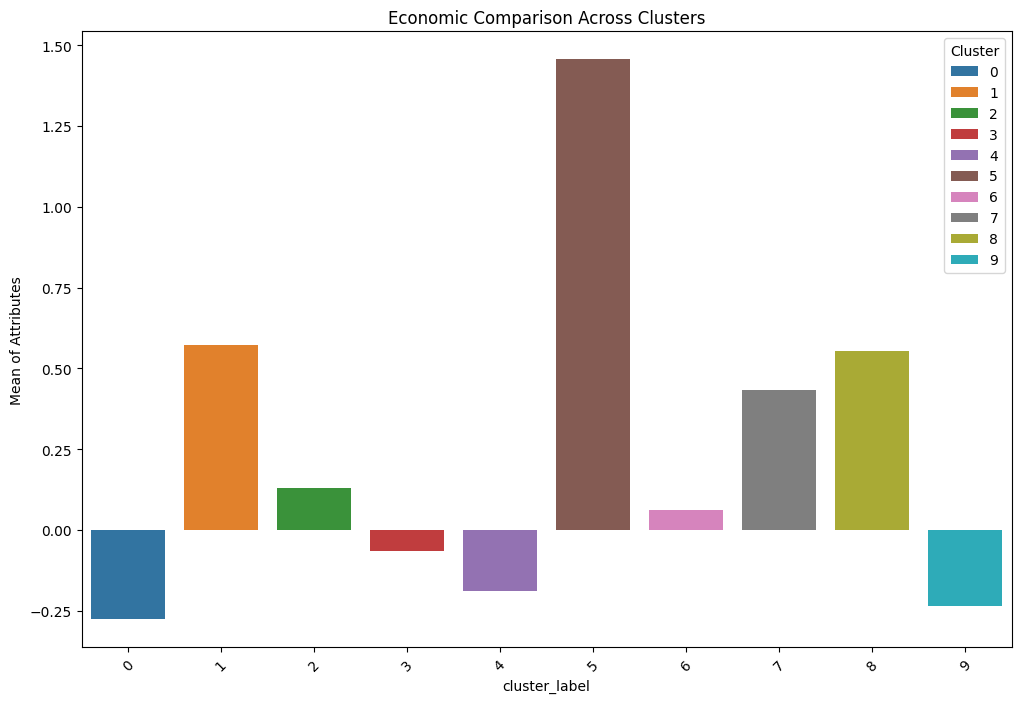

,PERNP,PINCP,WAGP,HINCP,FINCP,INSP
cluster_label,,,,,,
0,-0.257722,-0.242188,-0.254811,-0.349738,-0.328636,-0.226358
1,0.583130,0.575958,0.595293,0.856462,0.735299,0.085457
2,-0.015224,0.107577,-0.010517,0.074273,0.022421,0.595627
3,-0.056075,-0.052037,-0.057767,-0.036652,-0.074956,-0.115189
4,-0.201764,-0.066395,-0.197647,-0.271316,-0.238545,-0.153404
5,1.449335,1.405004,1.318823,2.173880,1.902487,0.486863
6,0.132425,0.142410,0.144002,0.064221,-0.012092,-0.105166
7,0.314111,0.359412,0.301387,0.622012,0.549025,0.444444
8,0.309015,0.427809,0.318938,0.905903,0.804449,0.556115


In [89]:
econ_indicators = ['PERNP', 'PINCP', 'WAGP', 'HINCP', 'FINCP', 'INSP']
compare_cluster_metrics(final_pp_df,econ_indicators,'Economic Comparison Across Clusters')

### Population Indicators

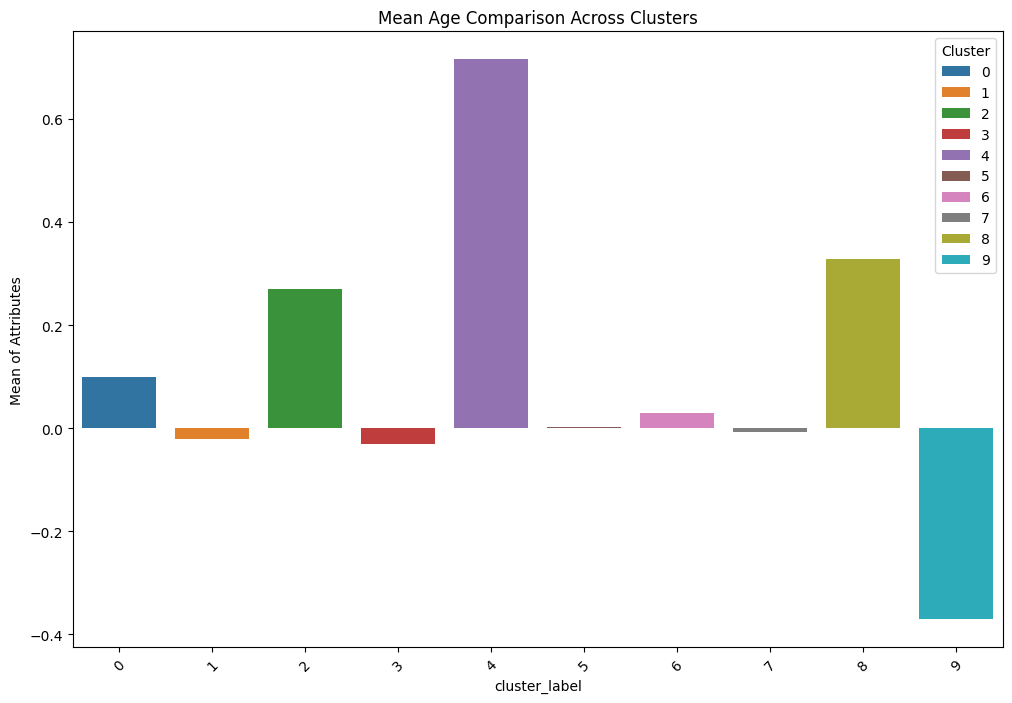

,AGEP
cluster_label,
0,0.099632
1,-0.021150
2,0.270001
3,-0.031086
4,0.715344
5,0.003242
6,0.029588
7,-0.006350
8,0.329121


In [90]:
demog_indicators = ['AGEP']
compare_cluster_metrics(final_pp_df,demog_indicators,'Mean Age Comparison Across Clusters')

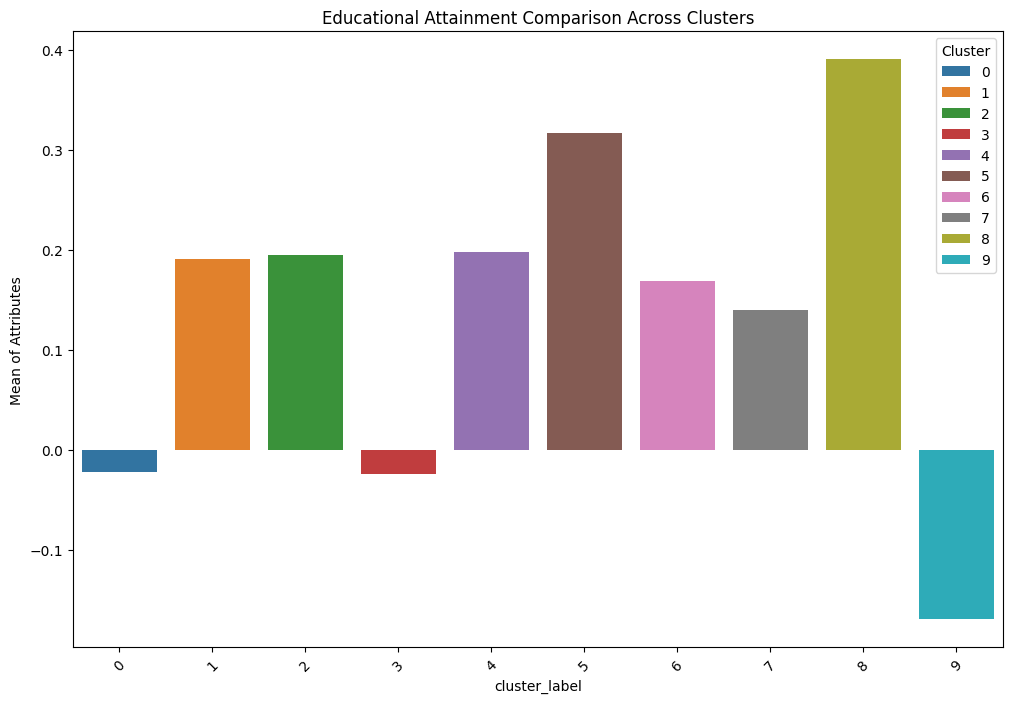

,SCHL
cluster_label,
0,-0.022068
1,0.190849
2,0.194770
3,-0.024392
4,0.197722
5,0.316812
6,0.169019
7,0.139293
8,0.390298


In [91]:
education_indicator = ['SCHL']
compare_cluster_metrics(final_pp_df,education_indicator,'Educational Attainment Comparison Across Clusters')

### Housing Indicators

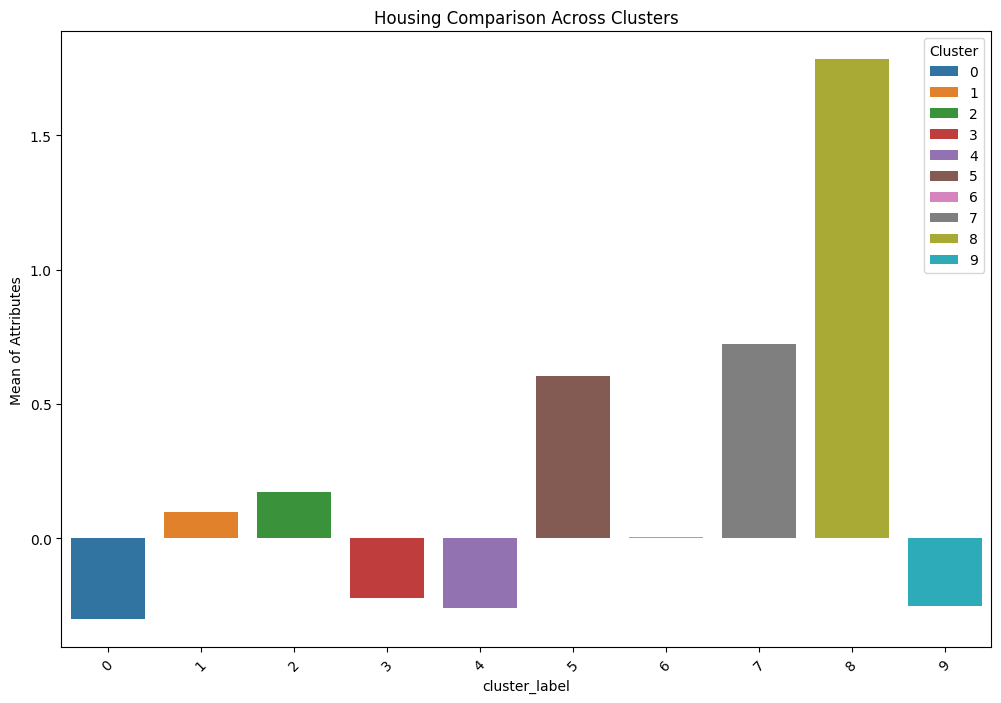

,SMOCP,MRGP,GRNTP,VALP,TAXAMT
cluster_label,,,,,
0,-0.334986,-0.263712,-0.247901,-0.283408,-0.375972
1,0.193898,0.084687,-0.067448,0.061421,0.226516
2,0.275294,0.095898,-0.147991,0.265710,0.368618
3,-0.195815,-0.225880,-0.154672,-0.214780,-0.307840
4,-0.319166,-0.238732,-0.230916,-0.219686,-0.292119
5,0.874369,0.550522,-0.081324,0.714583,0.958520
6,0.045380,-0.002355,-0.055509,0.000309,0.031546
7,1.058067,0.811259,-0.109085,0.737879,1.125628
8,0.805379,0.375447,-0.147541,6.948746,0.929311


In [92]:
housing_indicators = ['SMOCP', 'MRGP', 'GRNTP', 'VALP', 'TAXAMT']
compare_cluster_metrics(final_pp_df,housing_indicators,'Housing Comparison Across Clusters')

### Workforce Indicators

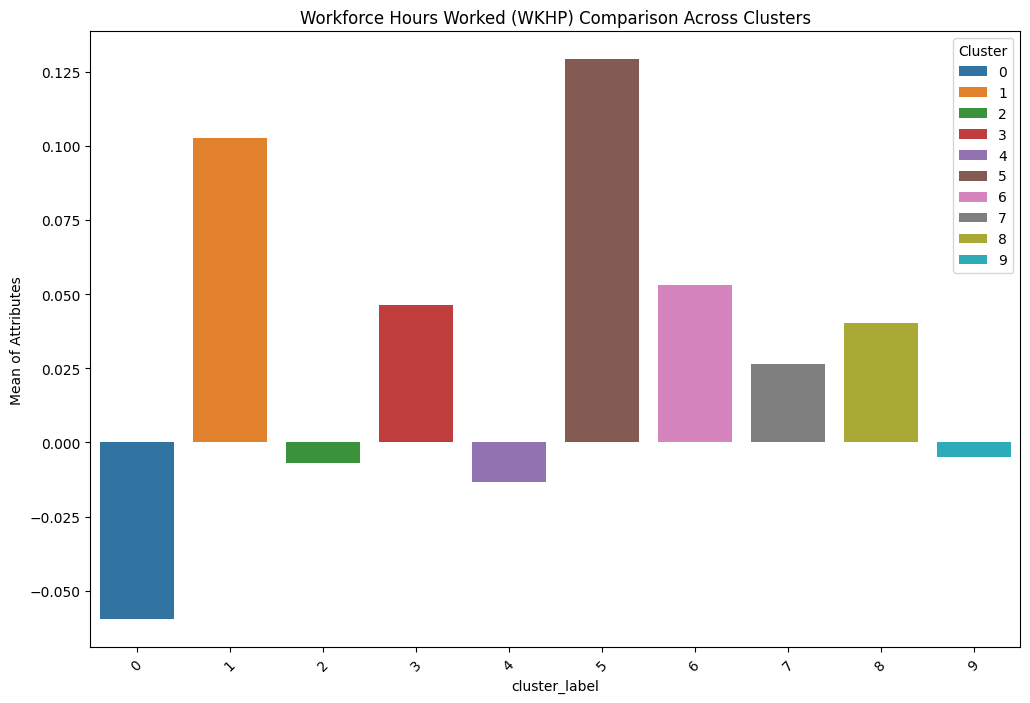

,WKHP
cluster_label,
0,-0.059676
1,0.102758
2,-0.006767
3,0.046475
4,-0.013339
5,0.129156
6,0.053063
7,0.026519
8,0.040347


In [93]:
workforce_indicators = ['WKHP'] # INDP & WKHP
compare_cluster_metrics(final_pp_df,workforce_indicators,'Workforce Hours Worked (WKHP) Comparison Across Clusters')

**Insights Obtained & Comments**


---


*   **Cluster 0** - The Average Group: Represents an average group with no significant deviations and lower workforce engagement.
*  **Cluster 1** - The Economically Active Group: Consists of economically active individuals with strong educational backgrounds and significant workforce engagement.
*  **Cluster 2** - The Educated Youth: Characterized by younger, educated individuals with stable economic indicators and potential for future growth.
*  **Cluster 3** - The Emerging Workers: Represents a younger group actively working to improve their socio-economic status.
*  **Cluster 4** - The Senior Group: Includes the oldest individuals, likely retired, with lower economic and housing indicators.
*  **Cluster 5** - The Affluent Professionals: Stands out as the most prosperous group with high education levels and significant workforce engagement.
*  **Cluster 6** - The Middle Class: Represents the middle class with a balanced socio-economic profile and higher workforce engagement.
*  **Cluster 7** - The Stable Seniors: Includes older individuals with stable economic conditions and high housing values, likely due to semi-retirement.
*  **Cluster 8** - The Wealthy Homeowners: Characterized by highly educated, older individuals with the most valuable housing and a stable, affluent lifestyle.
*  **Cluster 9** - The Young Starters: Represents the youngest group, starting their careers with more affordable housing options and actively building their professional lives.


## Final Results: United States Real Estate Market Heatmap

### Census Bureau Shapefile Data Extraction

Upload 'CENSUS_SHAPEFILES_EXTRACTED_FINAL.zip,' which can be found in the data folder on Git.

In [94]:
from google.colab import files
uploaded = files.upload() # wait times are expected, do not terminate

Saving CENSUS_SHAPEFILES_EXTRACTED_FINAL.zip to CENSUS_SHAPEFILES_EXTRACTED_FINAL.zip


In [95]:
# extract
!unzip /content/CENSUS_SHAPEFILES_EXTRACTED_FINAL.zip -d /content/CENSUS_SHAPEFILES_EXTRACTED_FINAL

Archive:  /content/CENSUS_SHAPEFILES_EXTRACTED_FINAL.zip
   creating: /content/CENSUS_SHAPEFILES_EXTRACTED_FINAL/CENSUS_SHAPEFILES_EXTRACTED_FINAL/
  inflating: /content/CENSUS_SHAPEFILES_EXTRACTED_FINAL/CENSUS_SHAPEFILES_EXTRACTED_FINAL/tl_2021_56_puma10.prj  
  inflating: /content/CENSUS_SHAPEFILES_EXTRACTED_FINAL/__MACOSX/CENSUS_SHAPEFILES_EXTRACTED_FINAL/._tl_2021_56_puma10.prj  
  inflating: /content/CENSUS_SHAPEFILES_EXTRACTED_FINAL/CENSUS_SHAPEFILES_EXTRACTED_FINAL/tl_2021_34_puma10.prj  
  inflating: /content/CENSUS_SHAPEFILES_EXTRACTED_FINAL/__MACOSX/CENSUS_SHAPEFILES_EXTRACTED_FINAL/._tl_2021_34_puma10.prj  
  inflating: /content/CENSUS_SHAPEFILES_EXTRACTED_FINAL/CENSUS_SHAPEFILES_EXTRACTED_FINAL/tl_2021_30_puma10.shx  
  inflating: /content/CENSUS_SHAPEFILES_EXTRACTED_FINAL/__MACOSX/CENSUS_SHAPEFILES_EXTRACTED_FINAL/._tl_2021_30_puma10.shx  
  inflating: /content/CENSUS_SHAPEFILES_EXTRACTED_FINAL/CENSUS_SHAPEFILES_EXTRACTED_FINAL/tl_2021_34_puma10.shp.ea.iso.xml  
  inflatin

In [96]:
# merge location shapefile metadata into a gdf
import os
import geopandas as gpd

shapefiles = [os.path.join('/content/CENSUS_SHAPEFILES_EXTRACTED_FINAL/CENSUS_SHAPEFILES_EXTRACTED_FINAL', f) for f in os.listdir('/content/CENSUS_SHAPEFILES_EXTRACTED_FINAL/CENSUS_SHAPEFILES_EXTRACTED_FINAL') if f.endswith('.shp')]

gdfs = [gpd.read_file(shp) for shp in shapefiles]
full_gdf = pd.concat(gdfs, ignore_index=True)

In [ ]:
full_gdf.head()

,STATEFP10,PUMACE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,40,01001,4001001,Oklahoma County (Southwest)--Oklahoma City (We...,G6120,S,147195909,590423,+35.4315252,-097.6102580,"POLYGON ((-97.54786 35.37713, -97.55055 35.377..."
1,40,01005,4001005,Oklahoma County (Southeast)--Oklahoma City (Ea...,G6120,S,268015358,239845,+35.4101530,-097.3689121,"POLYGON ((-97.44479 35.43524, -97.44475 35.435..."
2,40,00602,4000602,"Stephens, Caddo, Comanche (North), Tillman, Je...",G6120,S,12805275380,204776544,+34.2604599,-097.9627659,"POLYGON ((-98.25402 35.37680, -98.25383 35.376..."
3,40,00400,4000400,Southwest Oklahoma PUMA,G6120,S,18204917718,127476035,+35.1969701,-099.3515237,"POLYGON ((-98.61805 35.18967, -98.61804 35.189..."
4,40,00601,4000601,Comanche County (Central)--Lawton City PUMA,G6120,S,1387934885,4118331,+34.5850897,-098.4282449,"POLYGON ((-98.40962 34.44885, -98.41077 34.448..."


In [97]:
# clean NAMELSAD10 column for easy joins later
full_gdf['NAMELSAD10'] = full_gdf['NAMELSAD10'].str.replace(' PUMA', '')

In [98]:
# JOINS
final_pp_df['PUMA_DESC'] = final_pp_df['PUMA_DESC'].astype(str)
full_gdf['NAMELSAD10'] = full_gdf['NAMELSAD10'].astype(str)

heatmap_df = final_pp_df.merge(full_gdf, left_on='PUMA_DESC', right_on='NAMELSAD10')

In [99]:
heatmap_df.columns

Index(['PERNP', 'PINCP', 'WAGP', 'HINCP', 'FINCP', 'TAXAMT', 'SMOCP', 'SCHL',
       'AGEP', 'VEH', 'ELEP', 'MRGP', 'INDP', 'WKHP', 'GASP', 'INSP',
       'MAR_5.0', 'HHLDRAGEP', 'SEX', 'GRNTP', 'VALP', 'cluster_label',
       'PUMA_DESC', 'STATEFP10', 'PUMACE10', 'GEOID10', 'NAMELSAD10',
       'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10',
       'INTPTLON10', 'geometry'],
      dtype='object')

In [101]:
heatmap_df_final = heatmap_df[['cluster_label','NAMELSAD10','geometry']]

In [102]:
heatmap_df_final[heatmap_df_final['NAMELSAD10']=='York County (North)--Weigelstown'] # TEST3 - WORKS

,cluster_label,NAMELSAD10,geometry
2119,4,York County (North)--Weigelstown,"POLYGON ((-76.83626 39.88755, -76.83644 39.887..."


In [ ]:
heatmap_df_final.head()

,cluster_label,NAMELSAD10,geometry
0,3,"Ada (North), Payette, Canyon (North), Gem & Wa...","POLYGON ((-116.23517 43.71785, -116.23431 43.7..."
1,3,Ada County (Central)--Meridian (Northeast) & B...,"POLYGON ((-116.35419 43.67512, -116.35417 43.6..."
2,6,Ada County (Northeast)--Boise (North & West) &...,"POLYGON ((-116.23598 43.61866, -116.23697 43.6..."
3,9,Ada County (South)--Boise (South) & Kuna Cities,"POLYGON ((-116.21330 43.11233, -116.21462 43.1..."
4,3,Adams & Franklin (Southeast) Counties,"POLYGON ((-76.99960 39.80391, -76.99959 39.801..."


### Heatmap: United States RE Market & Clusters

In [104]:
type(heatmap_df_final)

pandas.core.frame.DataFrame

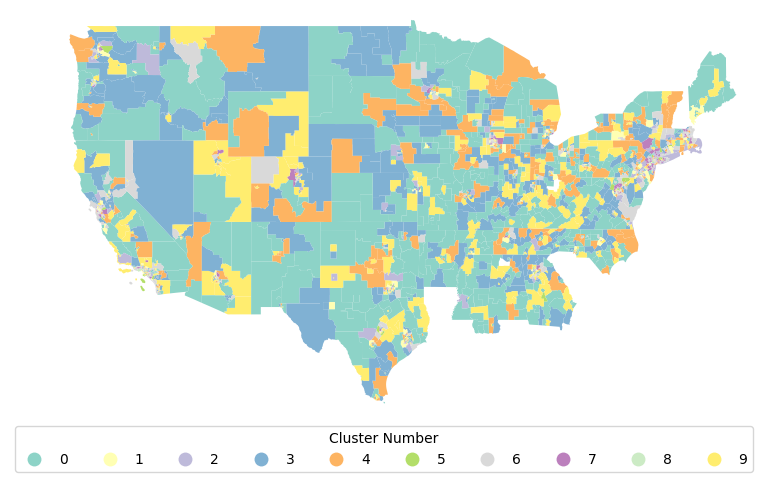

In [103]:
# ---PLOTTING---
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt

# convert pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(heatmap_df_final, geometry='geometry')

gdf['cluster_label'] = gdf['cluster_label'].astype('category')
fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the size as needed.

# plot with horizontal legend.
gdf.plot(column='cluster_label', ax=ax, legend=True, cmap='Set3', categorical=True,
         legend_kwds={'title': 'Cluster Number', 'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.15),
                      'ncol': len(gdf['cluster_label'].cat.categories)})

ax.axis('off')

# adjust the figure size and layout
fig.subplots_adjust(bottom=0.2)


ax.set_xlim([-130, -65])  # set x-axis limits to cover the mainland US.
ax.set_ylim([25, 50])     # set y-axis limits to cover the mainland US.

plt.show()

### Heatmap Summary

In [105]:
cluster_dfs = {}
for cluster_label in gdf['cluster_label'].unique():
    # filter the GeoDataFrame for each unique cluster
    cluster_df = gdf[gdf['cluster_label'] == cluster_label]
    # create a simple DataFrame for easier manipulation or export, including only the city names and cluster labels
    simple_df = cluster_df[['NAMELSAD10', 'cluster_label']]
    # store in a dictionary for easy access
    cluster_dfs[cluster_label] = simple_df

for cluster_label, df in cluster_dfs.items():
    print(f"DataFrame for Cluster {cluster_label} (first few rows):")
    print(df.head(10))
    print("\n")

all_clusters_df = pd.concat(cluster_dfs.values(), ignore_index=True)

# save the concatenated DataFrame to a CSV file
all_clusters_df.to_csv('clusters_with_city_names.csv', index=False)

print("All clusters saved to 'clusters_with_city_names.csv'.")

DataFrame for Cluster 3 (first few rows):
                                           NAMELSAD10 cluster_label
0   Ada (North), Payette, Canyon (North), Gem & Wa...             3
1   Ada County (Central)--Meridian (Northeast) & B...             3
4               Adams & Franklin (Southeast) Counties             3
37  Allegheny County (North)--Franklin Park Boroug...             3
50  Anderson, Union & Knox (North) Counties--Oak R...             3
54  Anne Arundel County (Northwest)--Severn, Odent...             3
55  Anne Arundel County (Southeast)--Annapolis Cit...             3
59  Arapahoe (Northwest) & Adams (Southwest) Count...             3
64          Ark-Tex COG (East)--Bowie & Cass Counties             3
84  Atlanta Regional Commission (Northeast)--Gwinn...             3


DataFrame for Cluster 6 (first few rows):
                                           NAMELSAD10 cluster_label
2   Ada County (Northeast)--Boise (North & West) &...             6
7   Adams County (West Central